In [1]:
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
import re
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from functools import lru_cache

In [2]:
warnings.filterwarnings("ignore", category=UserWarning, module="openpyxl.styles.stylesheet")

# DOPP 24/25, Group 27, Exercise 2

In order to maintain some level of structure on that big notebook, we will be structuring it in the following sections:

* Introduction  
* Imports and constants
* Read-in function for all datasets
* Dataset descriptions and small visualizations
* Missing data analysis
* Preprocessing functions
* Question 1 to 3 as well as their answers

## Introduction
The adoption of renewable energy has become a corner stone of the european union in combating climate change and in ensuring long term sustainability. 
In the last decade, it is often claimed that Europe has made significant progress in the transition from fossil fuels to cleaner energy sources, driven by ambitious policies such as the European Green Deal, REPowerEU Plan, and the Fit-for-55 package. 

In this project our group has decided to use modern data science methodologies to investigate the following questions: 


1. How is the adoption of renewable energy in Europe evolving?
2. How is the adoption of different types of renewable energy evolving?
3. Are there characteristics of countries that correlate with their level of adoption of renewable energy?

## Imports and Constants

In [3]:
# General Definitions and Configurations

# Share of energy from renewable sources                        
NRG_IND_REN = 'data/nrg_ind_ren_spreadsheet.xlsx'               # https://ec.europa.eu/eurostat/databrowser/view/nrg_inf_epcrw__custom_13973000/default/table?lang=en
# Electricity production capacities for renewables and wastes
NRG_INF_EPCRW = 'data/nrg_inf_epcrw_spreadsheet.xlsx'           # https://ec.europa.eu/eurostat/databrowser/view/nrg_ind_ren/default/table?lang=en    
# Simplified energy balances           
NRG_BAL_S = 'data/nrg_bal_s__custom_13973102_spreadsheet.xlsx'  # https://ec.europa.eu/eurostat/databrowser/view/nrg_bal_s__custom_13973102/default/table?lang=en
# Supply and transformation of solid fossil fuels
NRG_CB_SFFM = 'data/nrg_cb_sffm_spreadsheet.xlsx'               # https://ec.europa.eu/eurostat/databrowser/view/nrg_cb_sffm/default/table?lang=en 
# Electricity prices for household consumers          
NRG_PC_204 = 'data/nrg_pc_204_spreadsheet.xlsx'                 # https://ec.europa.eu/eurostat/databrowser/view/nrg_pc_204/default/table?lang=en
# Population by educational attainment level, sex and age
EDAT_LFSE_03 = 'data/edat_lfse_03_spreadsheet.xlsx'             # https://ec.europa.eu/eurostat/databrowser/view/edat_lfse_03/default/table?lang=en
# Gross domestic product at market prices
TEC00001 = 'data/tec00001_page_spreadsheet.xlsx'                # https://ec.europa.eu/eurostat/databrowser/view/tec00001/default/table?lang=en

# Creating groups for grouped analysis
EU_COUNTRIES = {
    "Austria", "Belgium", "Bulgaria", "Croatia", "Cyprus", "Czechia", "Denmark",
    "Estonia", "Finland", "France", "Germany", "Greece", "Hungary", "Ireland", "Italy",
    "Latvia", "Lithuania", "Luxembourg", "Malta", "Netherlands", "Poland", "Portugal",
    "Romania", "Slovakia", "Slovenia", "Spain", "Sweden"
}

SCHENGEN_COUNTRIES = {
    "Austria", "Belgium", "Czechia", "Denmark", "Estonia", "Finland", "France", "Germany",
    "Greece", "Hungary", "Iceland", "Italy", "Latvia", "Liechtenstein", "Lithuania",
    "Luxembourg", "Malta", "Netherlands", "Norway", "Poland", "Portugal", "Slovakia",
    "Slovenia", "Spain", "Sweden", "Switzerland"
}

EUROZONE_MEMBERS = {
    "Austria", "Belgium", "Cyprus", "Estonia", "Finland",
    "France", "Germany", "Greece", "Ireland", "Italy",
    "Latvia", "Lithuania", "Luxembourg", "Malta",
    "Netherlands", "Portugal", "Slovakia", "Slovenia", "Spain"
}

NON_EUROZONE_MEMBERS = {
    "Bulgaria", "Croatia", "Czech Republic",
    "Denmark", "Hungary", "Poland", "Romania", "Sweden"
}

CORE_ECONOMIES = ["Germany", "France", "Netherlands", "Austria", "Sweden", "Denmark"]
MEDITERRANEAN_ECONOMIES = ["Spain", "Italy", "Greece", "Portugal", "Malta", "Cyprus"]
EASTERN_GROWTH_ECONOMIES = ["Poland", "Czech Republic", "Hungary", "Slovakia", "Slovenia", "Croatia"]
GREEN_LEADERS = ["Sweden", "Denmark", "Finland", "Germany", "Netherlands"]
NORDIC_GREEN_LEADERS = ["Finland", "Sweden", "Denmark"]
PERIPHERAL_NATIONS = ["Bulgaria", "Romania", "Latvia", "Lithuania", "Estonia"]


ENVIRONMENTAL_CHALLENGES = ["Bulgaria", "Romania", "Poland", "Hungary", "Greece"]
BALKAN_COUNTRIES = ["Bulgaria", "Romania", "Croatia", "Slovenia", "Greece"]
BENELUX_COUNTRIES = ["Belgium", "Netherlands", "Luxembourg"]
DIGITAL_LEADERS = ["Sweden", "Denmark", "Netherlands", "Finland", "Germany", "Estonia"]
DIGITAL_LAGGARDS = ["Bulgaria", "Romania", "Greece", "Croatia", "Slovakia"]
HIGHLY_URBANIZED = ["Belgium", "Netherlands", "Germany", "France", "Luxembourg"]
MODERATELY_URBANIZED = ["Spain", "Italy", "Poland", "Hungary", "Czech Republic"]
LOW_URBANIZED = ["Romania", "Bulgaria", "Latvia", "Lithuania", "Estonia"]
NET_CONTRIBUTORS = ["Germany", "France", "Netherlands", "Sweden", "Denmark", "Austria"]
HIGH_RND_INVESTMENT = ["Sweden", "Finland", "Germany", "Netherlands", "Denmark"]
LOW_RND_INVESTMENT = ["Bulgaria", "Romania", "Greece", "Croatia", "Latvia"]
NET_BENEFICIARIES = [
    "Poland", "Romania", "Hungary", "Greece",
    "Portugal", "Bulgaria", "Lithuania", "Latvia"
]

In [4]:
def get_comparison_groups():
    all_entries = {}

    # Urbanization Levels
    # all_entries['URBANIZATION'] = {
    #     "highly_urbanized": HIGHLY_URBANIZED,
    #     "moderately_urbanized": MODERATELY_URBANIZED,
    #     "low_urbanized": LOW_URBANIZED
    # }

    # R&D Investment Levels
    all_entries['RND_INVESTMENT'] = {
        "high": HIGH_RND_INVESTMENT,
        "low": LOW_RND_INVESTMENT
    }

    # EU Budget Contributions
    all_entries['EU_BUDGET'] = {
        "net_contributors": NET_CONTRIBUTORS,
        "net_beneficiaries": NET_BENEFICIARIES
    }

    # Environmental Factors
    all_entries['ENVIRONMENT'] = {
        "green_leaders": GREEN_LEADERS,
        "environmental_challenges": ENVIRONMENTAL_CHALLENGES
    }

    # Digital Transformation
    all_entries['DIGITAL_TRANSFORMATION'] = {
        "digital_leaders": DIGITAL_LEADERS,
        "digital_laggards": DIGITAL_LAGGARDS
    }

    # Regional Groups
    #all_entries['REGIONAL_GROUPS'] = {
    #    "balkan_countries": BALKAN_COUNTRIES,
    #    "benelux_countries": BENELUX_COUNTRIES
    #}

    # EU Membership Groups
    #all_entries['EU_MEMBERSHIP'] = {
    #    "eu_countries": list(EU_COUNTRIES),
    #    "schengen_countries": SCHENGEN_COUNTRIES,
    #    "eurozone_members": EUROZONE_MEMBERS,
    #    "non_eurozone_members": NON_EUROZONE_MEMBERS
    #}

    # Nordic and Peripheral Nations
    #all_entries['OTHER_GROUPS'] = {
    #    "nordic_green_leaders": NORDIC_GREEN_LEADERS,
    #    "peripheral_nations": PERIPHERAL_NATIONS
    #}

    return all_entries

## Functions for Read In & Dataset Statistics

In [5]:
@lru_cache
def eurostat_dataset(path: str) -> pd.DataFrame:
    """ 
    This function reads in excel sheets paths for eurostat datasets
    and transforms them into multi-index dataframe
    """
    
    # retrieve sheets data and metadata from Summary sheet
    ## the time frequency and unit of measurement information 
    # is not a relevant index value since they are always the same
    ignore = ['Time frequency', 'Unit of measure']
    summary = pd.read_excel(
        path, sheet_name='Summary', 
        usecols=lambda col: \
            not col.startswith('Unnamed') and col not in ignore,
        index_col='Contents', skiprows=14
    )

    all = []

    # iterate over data sheets and pre-process them
    for sheet_name, config in summary.iterrows():

        # the valuable information starts with the row containing "TIME" indicating the start of the data table
        preview = pd.read_excel(path, sheet_name=sheet_name, usecols=[0])
        header_row = preview[preview.iloc[:, 0] == 'TIME'].index[0]

        data = pd.read_excel(
            path, sheet_name=sheet_name,
            usecols= lambda col: not str(col).startswith('Unnamed'),
            na_values=':', skiprows=header_row + 1
        )

        # Remove the first row "Geo (Label)"
        data = data.iloc[1:].reset_index(drop=True)

        # some sheets contain additional meta-data at the end which are seperated by a NaN value row from the actual data
        ## if we find such a row we remove all rows after
        first_blank_row_index = data.isnull().all(axis=1).idxmax() if data.isnull().all(axis=1).any() else None
        if first_blank_row_index is not None:
            data = data.loc[:first_blank_row_index - 1]

        # rename TIME to country
        data.rename(columns={'TIME': 'Country'}, inplace=True)

        # create multi-index based on config
        config_df = pd.DataFrame([config] * len(data), index=data.index)
        data = pd.concat([config_df, data], axis=1)
        data.set_index(['Country'] + list(config_df.columns), inplace=True)

        all.append(data)

    # merge them into one multi-index data frame 
    all = pd.concat(all).sort_index()
    
    return all

In [6]:
def _analyse_zeros_and_nans_in_dataframe(df: pd.DataFrame, label):

    # Exclude index columns from analysis
    df_columns_only = df.reset_index().iloc[:, len(df.index.names):]

    total_columns = len(df_columns_only.columns)

    # Columns with at least one NaN value
    nan_any_columns = df_columns_only.columns[df_columns_only.isna().any()].tolist()
    nan_any_percentage = len(nan_any_columns) / total_columns * 100

    # Columns with only NaN values
    nan_only_columns = df_columns_only.columns[df_columns_only.isna().all()].tolist()
    nan_only_percentage = len(nan_only_columns) / total_columns * 100

    # Columns with at least one 0 value
    zero_any_columns = df_columns_only.columns[(df_columns_only == 0).any()].tolist()
    zero_any_percentage = len(zero_any_columns) / total_columns * 100

    # Columns with only 0 values
    zero_only_columns = df_columns_only.columns[(df_columns_only == 0).all()].tolist()
    zero_only_percentage = len(zero_only_columns) / total_columns * 100

    # Percentage of NaN values per column
    nan_percentage_per_column = df_columns_only.isna().mean() * 100
    nan_columns_above_50 = nan_percentage_per_column[nan_percentage_per_column > 50].to_dict()

    # Percentage of 0 values per column
    zero_percentage_per_column = (df_columns_only == 0).mean() * 100
    zero_columns_above_50 = zero_percentage_per_column[zero_percentage_per_column > 50].to_dict()

    # Generate a print statement for the analysis
    print(f"\n  Total columns analyzed: {total_columns}")
    print(f"  Columns with at least one NaN value: {len(nan_any_columns)} ({nan_any_percentage:.2f}%); {_transform_years_list_to_range(nan_any_columns)}")
    print(f"  Columns with only NaN values: {len(nan_only_columns)} ({nan_only_percentage:.2f}%); {_transform_years_list_to_range(nan_only_columns)}")
    print(f"  Columns with at least one 0 value: {len(zero_any_columns)} ({zero_any_percentage:.2f}%); {_transform_years_list_to_range(zero_any_columns)}")
    print(f"  Columns with only 0 values: {len(zero_only_columns)} ({zero_only_percentage:.2f}%); {_transform_years_list_to_range(zero_only_columns)}")
    print(f"  Columns with >50% NaN values:")
    for col, perc in nan_columns_above_50.items():
        print(f"    {col}: {perc:.2f}%")
    print(f"  Columns with >50% 0 values:")
    for col, perc in zero_columns_above_50.items():
        print(f"    {col}: {perc:.2f}%")


def _plot_eu_vs_other_missing_data_by_time(df: pd.DataFrame, label):

    # Split into EU and non-EU DataFrames
    df_eu = df[df.index.get_level_values('Country').isin(EU_COUNTRIES)]
    df_non_eu = df[~df.index.get_level_values('Country').isin(EU_COUNTRIES)]

    # Missing values by time period for EU countries
    missing_per_time_eu = df_eu.isna().mean() * 100

    # Missing values by time period for non-EU countries
    missing_per_time_non_eu = df_non_eu.isna().mean() * 100

    # Create a figure with two subplots side by side
    _, axes = plt.subplots(1, 2, figsize=(12, 4))

    # EU Plot
    axes[0].bar(missing_per_time_eu.index, missing_per_time_eu.values, color='blue', alpha=0.7)
    axes[0].set_title(f'{label}: Missing Data by Time Period (EU Countries)')
    axes[0].set_xlabel('Time Periods')
    axes[0].set_ylabel('Percentage of Missing Data')
    axes[0].tick_params(axis='x', rotation=45, labelsize=8)

    # Non-EU Plot
    axes[1].bar(missing_per_time_non_eu.index, missing_per_time_non_eu.values, color='green', alpha=0.7)
    axes[1].set_title(f'{label}: Missing Data by Time Period (Non-EU Countries)')
    axes[1].set_xlabel('Time Periods')
    axes[1].set_ylabel('Percentage of Missing Data')
    axes[1].tick_params(axis='x', rotation=45, labelsize=8)

    # Adjust layout
    plt.tight_layout()
    plt.show()


def _plot_eu_vs_other_partially_missing_data_by_time(df, label):

    # Reset index to work with 'Country' column
    df_reset = df.reset_index()

    # Split into EU and non-EU DataFrames
    df_eu = df_reset[df_reset['Country'].isin(EU_COUNTRIES)]
    df_non_eu = df_reset[~df_reset['Country'].isin(EU_COUNTRIES)]

    # Analyze partial NaN columns for EU countries
    nan_percentage_eu = df_eu.isna().mean() * 100
    partial_nan_columns_eu = nan_percentage_eu[(nan_percentage_eu > 0) & (nan_percentage_eu < 100)]

    # Analyze partial NaN columns for non-EU countries
    nan_percentage_non_eu = df_non_eu.isna().mean() * 100
    partial_nan_columns_non_eu = nan_percentage_non_eu[(nan_percentage_non_eu > 0) & (nan_percentage_non_eu < 100)]

    # Create a figure with two subplots side by side
    _, axes = plt.subplots(1, 2, figsize=(12, 4))  # Total width 12, each plot width 6

    # Visualization for EU countries
    axes[0].bar(partial_nan_columns_eu.index, partial_nan_columns_eu.values, alpha=0.7, color='blue')
    axes[0].set_title(f'{label}: Partial NaN Data (EU Countries)')
    axes[0].set_xlabel('Column Names')
    axes[0].set_ylabel('Percentage of NaN Data')
    axes[0].tick_params(axis='x', rotation=45, labelsize=8)

    # Visualization for non-EU countries
    axes[1].bar(partial_nan_columns_non_eu.index, partial_nan_columns_non_eu.values, alpha=0.7, color='green')
    axes[1].set_title(f'{label}: Partial NaN Data (Non-EU Countries)')
    axes[1].set_xlabel('Column Names')
    axes[1].set_ylabel('Percentage of NaN Data')
    axes[1].tick_params(axis='x', rotation=45, labelsize=8)

    # Adjust layout
    plt.tight_layout()
    plt.show()


def _transform_years_list_to_range(years: list) -> str:

    if not years:
        return ""

    years = [int(year) for year in years]

    years = sorted(years)
    ranges = []
    start = years[0]
    end = years[0]

    for i in range(1, len(years)):
        if years[i] == years[i - 1] + 1:
            end = years[i]
        else:
            if start == end:
                ranges.append(f"{start}")
            else:
                ranges.append(f"{start}-{end}")
            start = end = years[i]

    # Add the final range
    if start == end:
        ranges.append(f"{start}")
    else:
        ranges.append(f"{start}-{end}")

    return ", ".join(ranges)


def _analyse_country_specific_statistics(df: pd.DataFrame):

    # 1. Report the timeframe
    years = [col for col in df.columns]  # Assuming all columns are years
    earliest_year = min(years)
    latest_year = max(years)
    print(f"\nTimeframe of the dataframe: {earliest_year} to {latest_year}")

    # 2. Report if there are years with no data at all
    near_zero_columns = df[years].sum(axis=0).abs() < 1e-6
    no_data_years = [year for year, is_zero in near_zero_columns.items() if is_zero]
    if no_data_years:
        print(f"Years with no data at all: {no_data_years}")
    else:
        print("All years have significant data.")

    # 3. Report countries with values near zero in all years
    country_names = df.index.get_level_values(0).unique()  # Extract country names from the first level of the index
    country_sums = df.groupby(level=0)[years].sum()  # Sum over all sub-levels for each country
    near_zero_countries = country_sums.sum(axis=1).abs() < 1e-6
    zero_data_countries = country_sums.index[near_zero_countries].tolist()
    if zero_data_countries:
        print(f"Countries with near-zero values in all years: {zero_data_countries}")
    else:
        print("All countries have significant data.")

    # 4. List missing years for countries with partially missing data
    partially_missing_data = {}
    for country, row in country_sums.iterrows():
        missing_years = [year for year in years if abs(row[year]) < 1e-6 and year not in no_data_years]
        if missing_years and len(missing_years) < len(years):
            partially_missing_data[country] = missing_years

    if partially_missing_data:
        if no_data_years:
            print(f"\nCountries with partially missing years (except {no_data_years}, because no data for that year at all):")
        else:
            print(f"\nCountries with partially missing years:")
        for country, missing_years in partially_missing_data.items():
            print(f"  {country}: {_transform_years_list_to_range(missing_years)}")
    else:
        print("No countries have partially missing years.")

    # 5. EU vs non-EU analysis
    eu_in_df = EU_COUNTRIES.intersection(country_sums.index)
    non_eu_in_df = set(country_sums.index).difference(EU_COUNTRIES)
    missing_eu_countries = EU_COUNTRIES.difference(country_sums.index)

    if missing_eu_countries:
        print(f"EU countries missing in the dataframe: {sorted(missing_eu_countries)}")
    else:
        print("All EU countries are in the dataframe.")

    if non_eu_in_df:
        print(f"Non-EU countries in the dataframe: {sorted(non_eu_in_df)}")
    else:
        print("No non-EU countries are in the dataframe.")

    # 6. Comparison of missing data: EU vs non-EU
    def calculate_missing_percentage(countries):
        subset = df.loc[list(countries)]
        total_cells = subset.size
        missing_cells = subset.isna().sum().sum()
        return (missing_cells / total_cells) * 100 if total_cells > 0 else 0

    def calculate_zeros_percentage(countries):
        subset = df.loc[list(countries)]
        total_cells = subset.size
        missing_cells = (subset.abs() < 1e-6).sum().sum()
        return (missing_cells / total_cells) * 100 if total_cells > 0 else 0

    eu_zero_percentage = calculate_zeros_percentage(eu_in_df)
    non_eu_zero_percentage = calculate_zeros_percentage(non_eu_in_df)

    print(f"\nPercentage of zero-values in EU countries: {eu_zero_percentage:.2f}%")
    print(f"Percentage of zero-values in non-EU countries: {non_eu_zero_percentage:.2f}%")

    eu_missing_percentage = calculate_missing_percentage(eu_in_df)
    non_eu_missing_percentage = calculate_missing_percentage(non_eu_in_df)

    print(f"Percentage of missing data (NaN's) in EU countries: {eu_missing_percentage:.2f}%")
    print(f"Percentage of missing data (NaN's) in non-EU countries: {non_eu_missing_percentage:.2f}%")


def analyze_dataframe(df, label):
    """
    Orchestrates the overall analysis of the DataFrame.

    Parameters:
        df (pd.DataFrame): The input DataFrame.
        label (str):

    Returns:
        dict: A dictionary with results from all analyses.
    """
    print(f"### Running Data Analysis for dataset '{label}' ###")
    _analyse_zeros_and_nans_in_dataframe(df, label)
    _analyse_country_specific_statistics(df)
    _ = _plot_eu_vs_other_missing_data_by_time(df, label)
    _ = _plot_eu_vs_other_partially_missing_data_by_time(df, label)


def _plot_eu_subset_filtered(df: pd.DataFrame, col: str, value: str, title_label: str, group1: list, group2: list):
    if col not in df.index.names and col is not None:
        raise ValueError(f"'{col}' is not part of the index")

    filtered_df = df.xs(value, level=col) if col is not None else df

    yearly_columns = [col for col in df.columns if col.isdigit()]

    if not yearly_columns:
        raise ValueError("No yearly columns found")

    # Initialize the plot
    plt.figure(figsize=(10, 7))

    all_years = list(map(str, sorted(map(int, yearly_columns))))

    # Plot Group 1
    for country in group1:
        if country in filtered_df.index.get_level_values('Country'):
            country_data = filtered_df.loc[(country, ), yearly_columns].reindex(all_years, axis=1, fill_value=float('nan'))
            plt.plot(
                country_data.columns,
                country_data.values.flatten(),
                linestyle='-',
                marker='s',
                label=f"Group 1: {country}",
                linewidth=2
            )

    # Plot Group 2
    for country in group2:
        if country in filtered_df.index.get_level_values('Country'):
            country_data = filtered_df.loc[(country, ), yearly_columns].reindex(all_years, axis=1, fill_value=float('nan'))
            plt.plot(
                country_data.columns,
                country_data.values.flatten(),
                linestyle='--',
                marker='o',
                label=f"Group 2: {country}",
                linewidth=2
            )

    # Add titles and labels
    plt.title(f"Yearly Data for {value} across: {title_label}", fontsize=14)
    plt.xlabel("Year", fontsize=12)
    plt.ylabel("Value", fontsize=12)
    plt.legend(title="Countries", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()

    plt.show()


def plot_comparison_groups(df: pd.DataFrame, col: str, value: str):

    groups = get_comparison_groups()

    for group_name, group_dict in groups.items():
        subgroup_names = list(group_dict.keys())

        # Pair subgroups for comparison if there are at least two subgroups
        for i in range(len(subgroup_names) - 1):
            for j in range(i + 1, len(subgroup_names)):
                subgroup1_name = subgroup_names[i]
                subgroup2_name = subgroup_names[j]

                countries1 = group_dict[subgroup1_name]
                countries2 = group_dict[subgroup2_name]

                # Combine countries into a filtered DataFrame
                df_filtered = df[df.index.get_level_values('Country').isin(countries1 + countries2)]

                # Plot the data for the two subgroups
                _plot_eu_subset_filtered(
                    df_filtered, col, value,
                    f"{group_name}: {subgroup1_name} vs {subgroup2_name}",
                    group1=countries1,
                    group2=countries2
                )

## Preprocessing functions

In [7]:
def subset_to_eu_countries(df: pd.DataFrame) -> pd.DataFrame:
    """
    Returns a subset of the DataFrame containing only EU countries.

    Parameters:
        df (pd.DataFrame): The input DataFrame with a multi-level index or a column labeled 'Country'.

    Returns:
        pd.DataFrame: A DataFrame containing only rows corresponding to EU countries.
    """
    if "Country" in df.index.names:
        # If 'Country' is part of the multi-index
        return df[df.index.get_level_values("Country").isin(EU_COUNTRIES)]
    elif "Country" in df.columns:
        # If 'Country' is a regular column
        return df[df["Country"].isin(EU_COUNTRIES)]
    else:
        raise ValueError("The DataFrame must have 'Country' as an index level or a column.")

def transform_special_characters_to_nan(df: pd.DataFrame, chars: list) -> pd.DataFrame:
    # Replace specified values with NaN
    transformed_df = df.replace(chars, np.nan)
    return transformed_df

def transform_df_from_monthly_to_yearly(df: pd.DataFrame) -> pd.DataFrame:
    df_new = df.copy()

    # Identify columns with names in the format 'YYYY-MM'
    monthly_columns = [col for col in df_new.columns if re.match(r"^\d{4}-\d{2}$", str(col))]

    # Group monthly columns by year
    year_groups = {}
    for col in monthly_columns:
        year = col.split('-')[0]  # Extract the year
        if year not in year_groups:
            year_groups[year] = []
        year_groups[year].append(col)

    # Sum monthly values into yearly totals
    for year, columns in year_groups.items():
        df_new[year] = df_new[columns].sum(axis=1)  # Create a new column for the yearly total
        df_new.drop(columns, axis=1, inplace=True)  # Remove the monthly columns

    return df_new

def sum_over_index_level(df: pd.DataFrame, level: str) -> pd.DataFrame:
    return df.groupby(level=[lvl for lvl in df.index.names if lvl != level]).sum()

def transform_df_from_semesterly_to_yearly(df: pd.DataFrame) -> pd.DataFrame:
    df_new = df.copy()

    # Identify columns with names in the format 'YYYY-SX'
    semesterly_columns = [col for col in df_new.columns if re.match(r"^\d{4}-S[12]$", str(col))]

    # Group semesterly columns by year
    year_groups = {}
    for col in semesterly_columns:
        year = col.split('-')[0]  # Extract the year
        if year not in year_groups:
            year_groups[year] = []
        year_groups[year].append(col)

    # Sum semesterly values into yearly totals
    for year, columns in year_groups.items():
        df_new[year] = df_new[columns].sum(axis=1)  # Create a new column for the yearly total
        df_new.drop(columns, axis=1, inplace=True)  # Remove the semesterly columns

    return df_new

## Dataset Descriptions

In the following section, general informations regarding the structure and content of the used datasets can be found.

### File Structures

Each of the 6 Excel-files contains two standardized worksheets for metadata, namely 'Summary' and 'Structure', and the actual data contained in that file is split across the (multiple) other worksheets.

* 'Summary' contains some metadata (e.g. short description,links), plus a list of additional worksheets where the actual data is contained. Each entry in that list consists at least of the worksheet-name, the unit of measure and the time frequency (always annual?), plus some file-specific columns.
* 'Structure' contains the descriptions (e.g., Germany is a geopolitical entity, or Exports is of dimension Energy Balance) for all dimensions mentioned in that Excel file. It is however not directly relevant when reading in the data for this project and also not processed.
* All other sheets (all of them contain actual data) have some kind of header (around 10 rows), then the actual data, and afterwards maybe some additional stuff (e.g. flag explanation). The actual data is always the same: Country as a row, value for a given year OR year+month as column.

### Dataset 1: Population by educational attainment level, sex and age


**Unit of measure**: Percentage (e.g., in 1995, 41.4% of Austrian Females between 15 and 64 had education level 0-2, while 5.9% had education level 5-8 and 52.7% had level 3-4) TODO is that correct?

**Available years in the dataset**: 1992-2023


**Time:** Annually

**This dataframe is multi-indexed by those 4 columns**:
- Country
- Sex (Total, Males, Females)
- Age class (a lot of different areas, all equal to or in between 15 and 64) TODO preprocess column
- Level of education TODO preprocess column


**Available flags**:

* (:) - not available
* (b) - break in time series
* (u) - low reliability
* (bu) - break in time series, low reliability

In [8]:
df_population_by_education_sex_age = eurostat_dataset(EDAT_LFSE_03)
label_df_population_by_education_sex_age = 'Population by educational, sex and age'
df_population_by_education_sex_age.head(5)

1992  \
Country Sex     Age class           International Standard Classification of Educat...        
Austria Females From 15 to 64 years Less than primary, primary and lower secondary ...  NaN   
                                    Tertiary education (levels 5-8)                     NaN   
                                    Upper secondary and post-secondary non-tertiary...  NaN   
                                    Upper secondary and post-secondary non-tertiary...  NaN   
                                    Upper secondary and post-secondary non-tertiary...  NaN   

                                                                                        1993  \
Country Sex     Age class           International Standard Classification of Educat...         
Austria Females From 15 to 64 years Less than primary, primary and lower secondary ...   NaN   
                                    Tertiary education (levels 5-8)                      NaN   
                                    Upper secondary and post-secondary non-tertiary...   NaN   
                                    Upper secondary and post-secondary non-tertiary...   NaN   
                                    Upper secondary and post-secondary non-tertiary...   NaN   

                                                                                        1994  \
Country Sex     Age class           International Standard Classification of Educat...         
Austria Females From 15 to 64 years Less than primary, primary and lower secondary ...   NaN   
                                    Tertiary education (levels 5-8)                      NaN   
                                    Upper secondary and post-secondary non-tertiary...   NaN   
                                    Upper secondary and post-secondary non-tertiary...   NaN   
                                    Upper secondary and post-secondary non-tertiary...   NaN   

                                                                                        1995  \
Country Sex     Age class           International Standard Classification of Educat...         
Austria Females From 15 to 64 years Less than primary, primary and lower secondary ...  41.4   
                                    Tertiary education (levels 5-8)                      5.9   
                                    Upper secondary and post-secondary non-tertiary...  52.7   
                                    Upper secondary and post-secondary non-tertiary...   NaN   
                                    Upper secondary and post-secondary non-tertiary...   NaN   

                                                                                        1996  \
Country Sex     Age class           International Standard Classification of Educat...         
Austria Females From 15 to 64 years Less than primary, primary and lower secondary ...  39.6   
                                    Tertiary education (levels 5-8)                      6.1   
                                    Upper secondary and post-secondary non-tertiary...  54.4   
                                    Upper secondary and post-secondary non-tertiary...   NaN   
                                    Upper secondary and post-secondary non-tertiary...   NaN   

                                                                                        1997  \
Country Sex     Age class           International Standard Classification of Educat...         
Austria Females From 15 to 64 years Less than primary, primary and lower secondary ...  36.6   
                                    Tertiary education (levels 5-8)                      6.1   
                                    Upper secondary and post-secondary non-tertiary...  57.3   
                                    Upper secondary and post-secondary non-tertiary...   NaN   
                                    Upper secondary and post-secondary non-tertiary...   NaN   

                                                        

### Running Data Analysis for dataset 'Population by educational, sex and age' ###

  Total columns analyzed: 32
  Columns with at least one NaN value: 32 (100.00%); 1992-2023
  Columns with only NaN values: 0 (0.00%); 
  Columns with at least one 0 value: 0 (0.00%); 
  Columns with only 0 values: 0 (0.00%); 
  Columns with >50% NaN values:
    1992: 86.01%
    1993: 84.56%
    1994: 84.56%
    1995: 80.35%
    1996: 74.74%
    1997: 70.53%
    1998: 69.15%
    1999: 60.77%
  Columns with >50% 0 values:

Timeframe of the dataframe: 1992 to 2023
All years have significant data.
All countries have significant data.

Countries with partially missing years:
  Austria: 1992-1994, 2000-2003
  Bosnia and Herzegovina: 1992-2020
  Bulgaria: 1992-1999
  Croatia: 1992-2001
  Cyprus: 1992-1998
  Czechia: 1992-1997
  Estonia: 1992-1997
  Euro area – 20 countries (from 2023): 1992-2001
  European Union - 27 countries (from 2020): 1992-2001
  Finland: 1992-1994
  France: 1992
  Germany: 1998
  Hungar

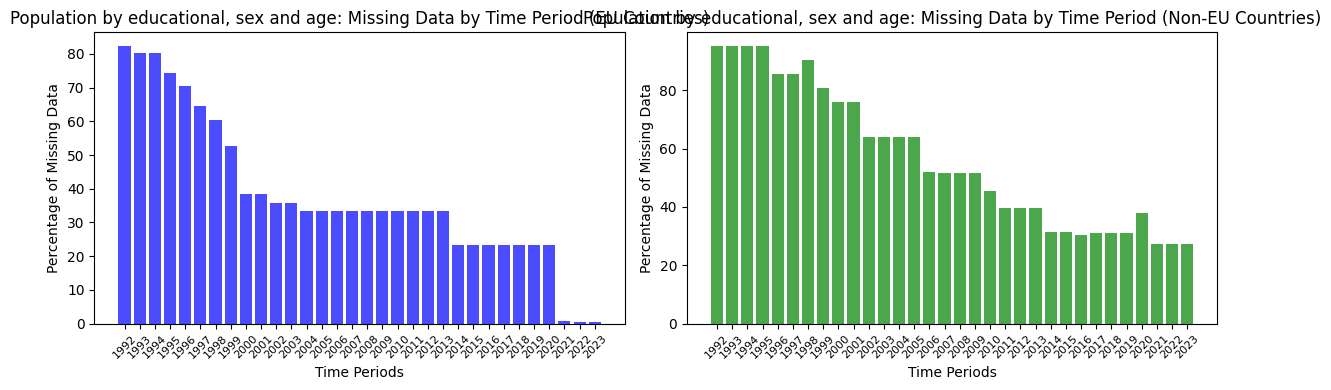

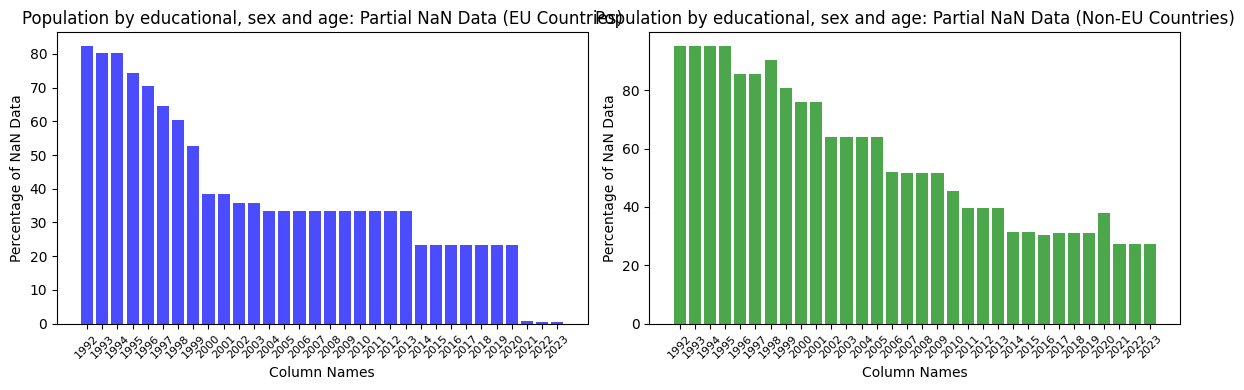

In [9]:
analyze_dataframe(df_population_by_education_sex_age, label_df_population_by_education_sex_age)

### Dataset 2: Simplified energy balances

**Unit of measure** Gigawatt-hours (GWh) (e.g., in 1990, Albanias Total Energy supply was 31086.839 GWh)

**Available years in the dataset**: 1990-2023

**Time:** Annually


One can see the annually aggregated values of various **energy balances structured by the following multi-level index**:
- Country
- Energy balance, which is either
    * Available for final consumption
    * Gross available energy
    * Primary energy consumption (Europe 2020-2023) (this one was removed, as there are a lot of NaN's for a lot of countries)
    * Total energy supply

(The column 'Standard international energy product classification (SIEC)' always contains the value 'Total' and will therefore be removed.)

**Available flags:**

* : - not available

In [10]:
df_energy_balances_by_country = eurostat_dataset(NRG_BAL_S)
label_df_energy_balances_by_country = 'Energy Balances by country'

# remove index column 'Standard international energy product classification (SIEC)'
df_reset = df_energy_balances_by_country.reset_index().drop(columns=['Standard international energy product classification (SIEC)'])

# filter out the rows for 'Primary energy consumption (Europe 2020-2030)'
df_filtered = df_reset[df_reset['Energy balance'] != 'Primary energy consumption (Europe 2020-2030)']
df_energy_balances_by_country = df_filtered.set_index(['Country', 'Energy balance'])

df_energy_balances_by_country = df_energy_balances_by_country.rename_axis(index={'Energy balance': 'energy_balance'})
df_energy_balances_by_country.head(5)

1990        1991        1992  \
Country energy_balance                                                        
Albania Available for final consumption   25468.502   17375.307   12569.078   
        Gross available energy            31086.839   21758.512   15796.031   
        Total energy supply               31086.839   21758.512   15796.031   
Austria Available for final consumption  227893.897  244309.138  238581.580   
        Gross available energy           294766.068  313485.830  301327.038   

                                               1993        1994        1995  \
Country energy_balance                                                        
Albania Available for final consumption   11468.949   12089.659   11453.356   
        Gross available energy            15480.885   16472.960   15471.151   
        Total energy supply               15480.885   16472.960   15471.151   
Austria Available for final consumption  242053.195  235953.495  245152.794   
        Gross available energy           305054.609  303773.918  317498.150   

                                               1996        1997        1998  \
Country energy_balance                                                        
Albania Available for final consumption   12201.205    9839.721   10933.849   
        Gross available energy            16511.396   14093.234   15541.509   
        Total energy supply               16511.396   14093.234   15541.509   
Austria Available for final consumption  267166.209  263916.004  269884.081   
        Gross available energy           337997.523  335556.397  341401.433   

                                               1999  ...        2014  \
Country energy_balance                               ...               
Albania Available for final consumption   18276.731  ...   25026.860   
        Gross available energy            21438.490  ...   27630.304   
        Total energy supply               20996.546  ...   27296.971   
Austria Available for final consumption  272453.840  ...  309853.366   
        Gross available energy           340853.604  ...  383071.687   

                                               2015        2016        2017  \
Country energy_balance                                                        
Albania Available for final consumption   23772.735   23340.493   24628.659   
        Gross available energy            25802.892   26814.224   28054.675   
        Total energy supply               25541.225   26338.335   27539.719   
Austria Available for final consumption  317253.321  325231.271  327814.050   
        Gross available energy           392418.001  397855.212  405013.188   

                                               2018        2019        2020  \
Country energy_balance                                                        
Albania Available for final consumption   25027.633   24439.519   23130.155   
        Gross available energy            27889.856   27754.335   25757.714   
        Total energy supply               27441.392   27134.947   25200.436   
Austria Available for final consumption  324387.335  329589.398  313467.428   
        Gross available energy           395747.100  404526.282  376263.004   

                                               2021        2022  2023  
Country energy_balance                                                 
Albania Available for final consumption   23877.241   23199.221   NaN  
        Gross available energy            27064.271   26043.416   NaN  
        Total energy supply               26530.401   25254.620   NaN  
Austria Available for final consumption  332200.753  311355.653   NaN  
        Gross available energy           398140.719  379252.652   NaN  

[5 rows x 34 columns]

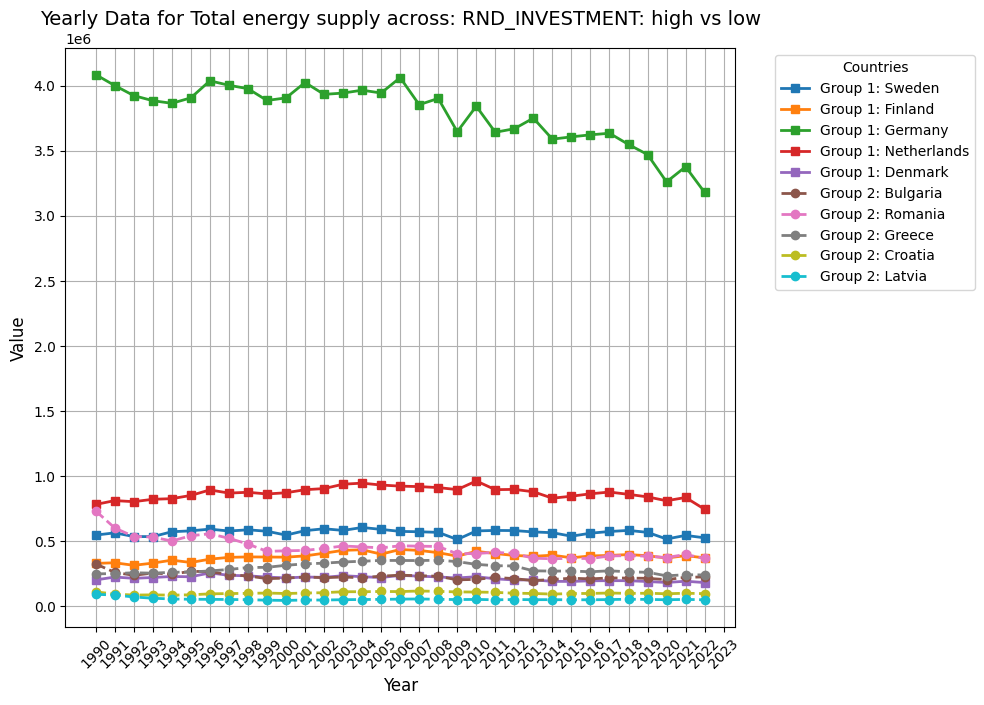

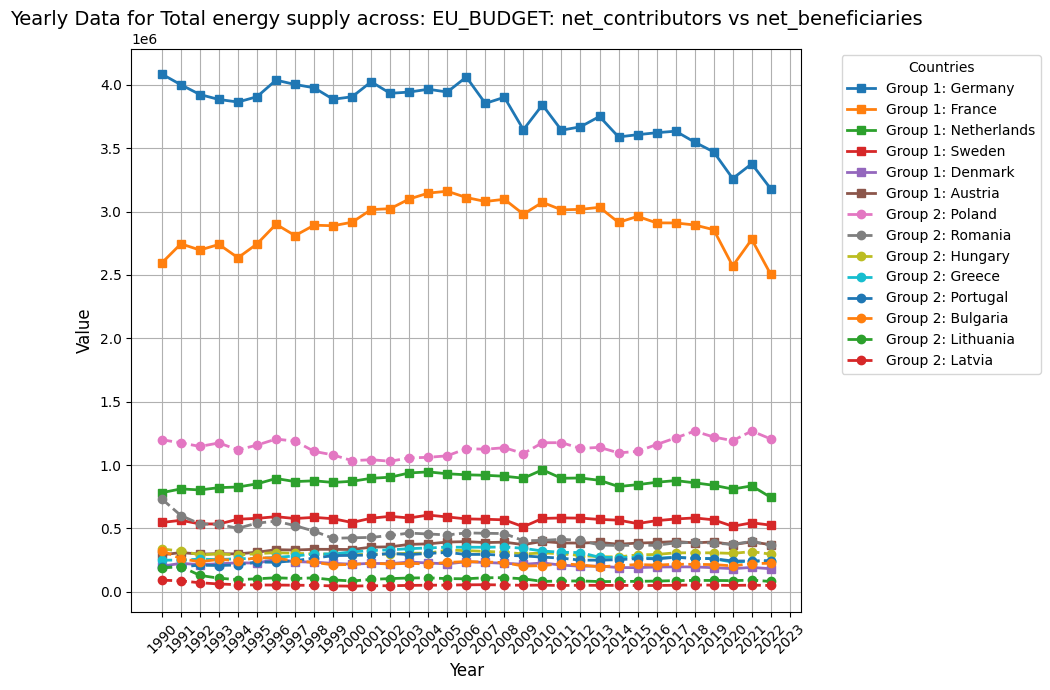

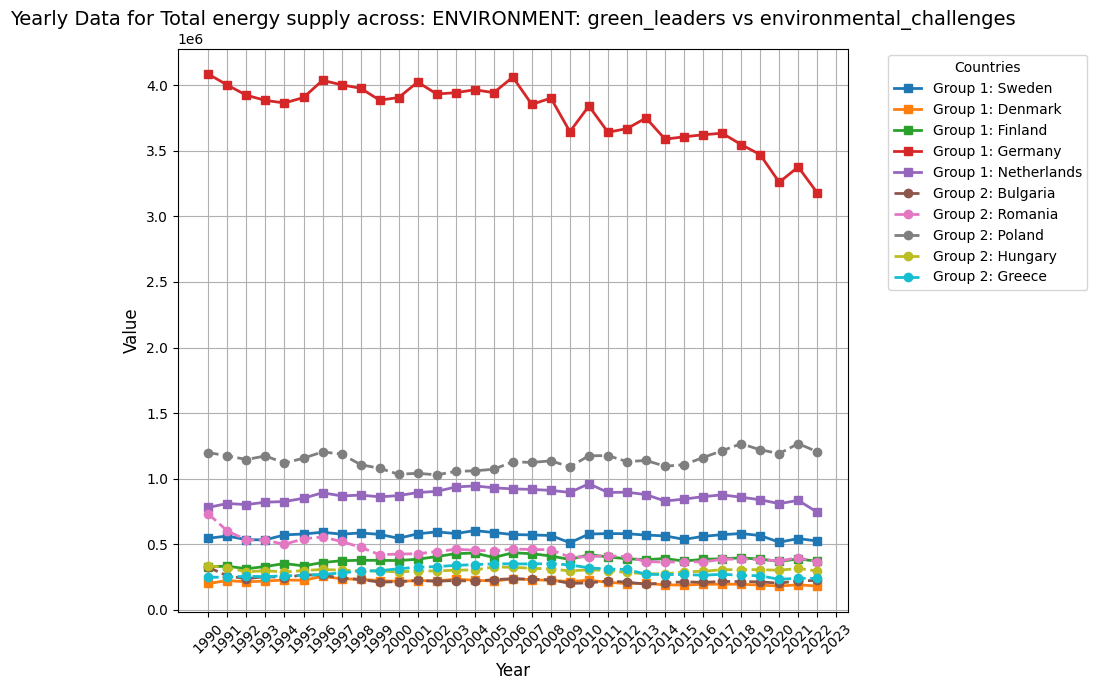

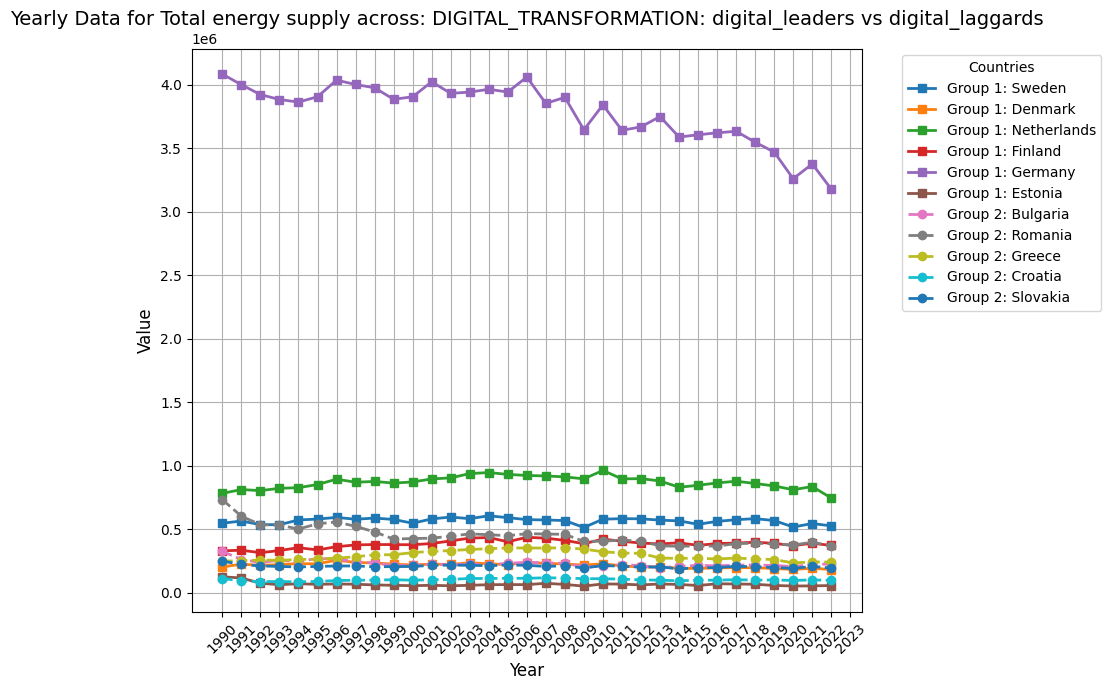

In [11]:
plot_comparison_groups(df_energy_balances_by_country, 'energy_balance', 'Total energy supply')

### Dataset 3: Supply and transformation of solid fossil fuels

**Unit of measure**: kT (kiloTons)


**Available years in the data**: 2008-2024

**Time**: Monthly, but converted to annually down below

**Multi-Level-Index is currently the following:**

* Country

* 'Standard international energy product classification (SIEC)', which can be:
    * Hard coal
    * Brown coal
    * Coke oven coke
    * Peat
    * Oil shale and oil sands

**Available flags:**
* : -	not available
* bn -	break in time series, not significant
* b -	break in time series
* e -	estimated
* n -	not significant
* p -	provisional
  

In [12]:
df_fossil_fuels_monthly_data = eurostat_dataset(NRG_CB_SFFM)
df_fossil_fuels_yearly_data = transform_df_from_monthly_to_yearly(df_fossil_fuels_monthly_data)
df_fossil_fuels = sum_over_index_level(df_fossil_fuels_yearly_data, 'Energy balance')
label_df_fossil_fuels = 'Fossil fuels by country'

df_fossil_fuels = df_fossil_fuels.rename_axis(index={'Standard international energy product classification (SIEC)': 'energy_product'})
df_fossil_fuels.head(15)

2008     2009     2010     2011     2012  \
Country energy_product                                                         
Albania Brown coal                     0      0.0      0.0      0.0      0.0   
        Coke oven coke                 0      0.0      0.0      0.0      0.0   
        Hard coal                      0      0.0      0.0      0.0      0.0   
        Oil shale and oil sands        0      0.0      0.0      0.0      0.0   
        Peat                           0      0.0      0.0      0.0      0.0   
Austria Brown coal                  94.0     50.0     60.0     76.0     52.0   
        Coke oven coke            7734.0   5953.0   7659.0   7819.0   7997.0   
        Hard coal                44385.0  53441.0  64746.0  52536.0  48900.0   
        Oil shale and oil sands        0      0.0      0.0      0.0      0.0   
        Peat                         0.0      0.0      0.0      0.0      0.0   
Belgium Brown coal                   0.0      0.0      0.0    605.0    578.0   
        Coke oven coke           19227.0  14496.0   7570.0  10711.0   9806.0   
        Hard coal                37164.0  27579.0   3791.0  41988.0  34383.0   
        Oil shale and oil sands        0      0.0      0.0      0.0      0.0   
        Peat                         0.0      0.0      0.0      0.0      0.0   

                                    2013     2014     2015     2016  \
Country energy_product                                                
Albania Brown coal                   0.0      0.0      0.0      0.0   
        Coke oven coke               0.0      0.0      0.0      0.0   
        Hard coal                    0.0      0.0      0.0      0.0   
        Oil shale and oil sands      0.0      0.0      0.0      0.0   
        Peat                         0.0      0.0      0.0      0.0   
Austria Brown coal                 166.0    188.0    136.0    134.0   
        Coke oven coke            9941.0   8289.0   8304.0   8215.0   
        Hard coal                47695.0  44629.0  37001.0  26634.0   
        Oil shale and oil sands      0.0      0.0      0.0      0.0   
        Peat                         0.0    216.0    206.0    230.0   
Belgium Brown coal                   0.0      0.0      0.0      0.0   
        Coke oven coke            8582.0  10357.0   8734.0   8726.0   
        Hard coal                30059.0  33886.0  30719.0  25002.0   
        Oil shale and oil sands      0.0      0.0      0.0      0.0   
        Peat                         0.0      0.0      0.0      0.0   

                                      2017       2018       2019       2020  \
Country energy_product                                                        
Albania Brown coal                   0.000      0.000      0.000      0.000   
        Coke oven coke               0.000      0.000      0.000      0.000   
        Hard coal                    0.000      0.000      0.000      0.000   
        Oil shale and oil sands      0.000      0.000      0.000      0.000   
        Peat                         0.000      0.000      0.000      0.000   
Austria Brown coal                  92.866    107.820    117.202    106.404   
        Coke oven coke            9156.240   8421.777   8340.236   7191.397   
        Hard coal                28609.889  29582.012  27092.669  20258.526   
        Oil shale and oil sands      0.000      0.000      0.000      0.000   
        Peat                         0.000      0.000      0.000      0.000   
Belgium Brown coal                   0.000      0.000    379.100    297.100   
        Coke oven coke            8498.348   8839.329   5857.300   3299.200   
        Hard coal                32262.796  39338.077  46094.400  41789.400   
        Oil shale and oil sands      0.000      0.000      0.000      0.000   
        Peat                         0.000      0.000      0.000      0.000   

                                      2021       2022       2023       2024  
Country energy_product                       

### Running Data Analysis for dataset 'Fossil fuels by country' ###

  Total columns analyzed: 17
  Columns with at least one NaN value: 0 (0.00%); 
  Columns with only NaN values: 0 (0.00%); 
  Columns with at least one 0 value: 17 (100.00%); 2008-2024
  Columns with only 0 values: 0 (0.00%); 
  Columns with >50% NaN values:
  Columns with >50% 0 values:
    2008: 67.80%
    2009: 67.80%
    2010: 67.32%
    2011: 63.41%
    2012: 63.90%
    2013: 61.95%
    2014: 61.46%
    2015: 59.51%
    2016: 59.51%
    2017: 52.68%
    2018: 51.71%
    2019: 51.22%
    2020: 50.73%
    2021: 52.20%
    2022: 50.73%
    2023: 52.68%
    2024: 54.63%

Timeframe of the dataframe: 2008 to 2024
All years have significant data.
Countries with near-zero values in all years: ['Iceland', 'Malta']

Countries with partially missing years:
  Albania: 2008-2021
  Bosnia and Herzegovina: 2008-2016
  Cyprus: 2012-2013
  European Union - 27 countries (from 2020): 2008-2012
  Georgia: 2008-2017
  Kosovo*: 2008-2

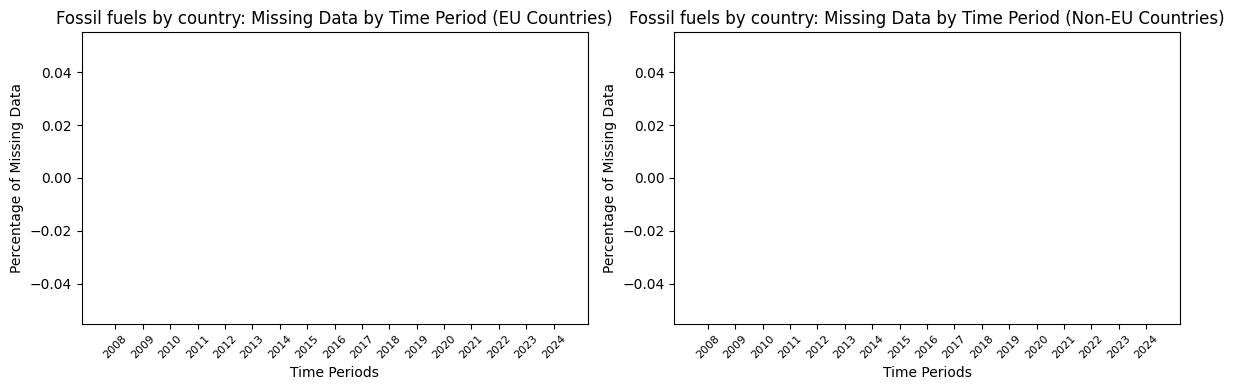

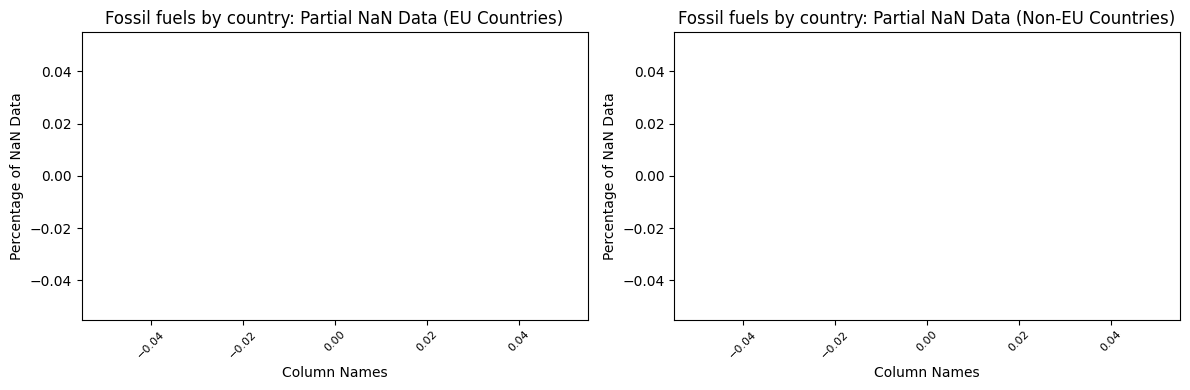

In [13]:
analyze_dataframe(df_fossil_fuels, label_df_fossil_fuels)

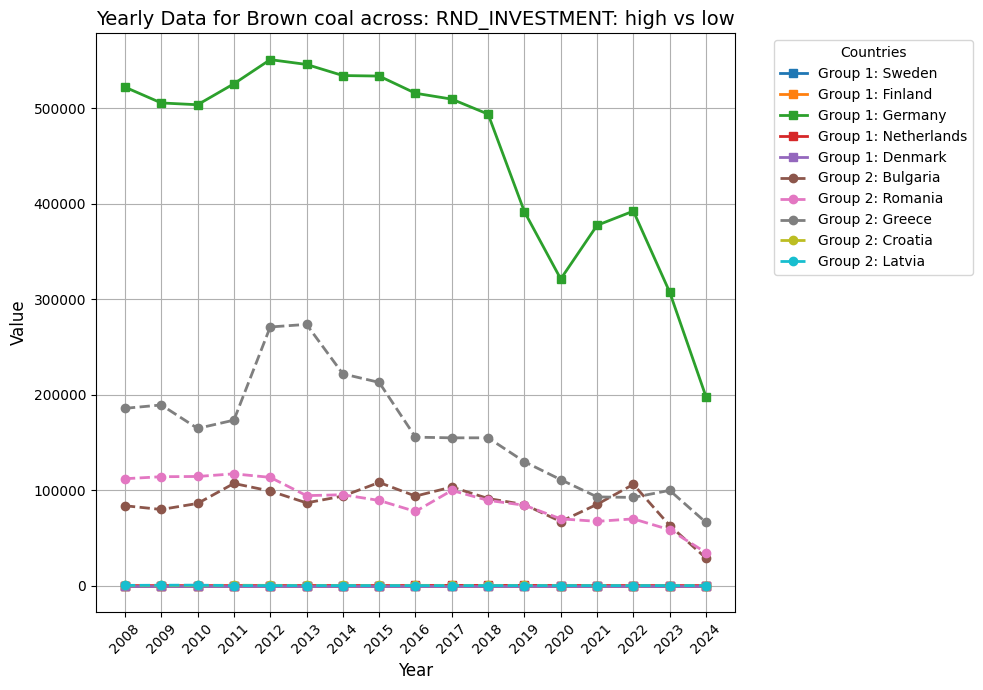

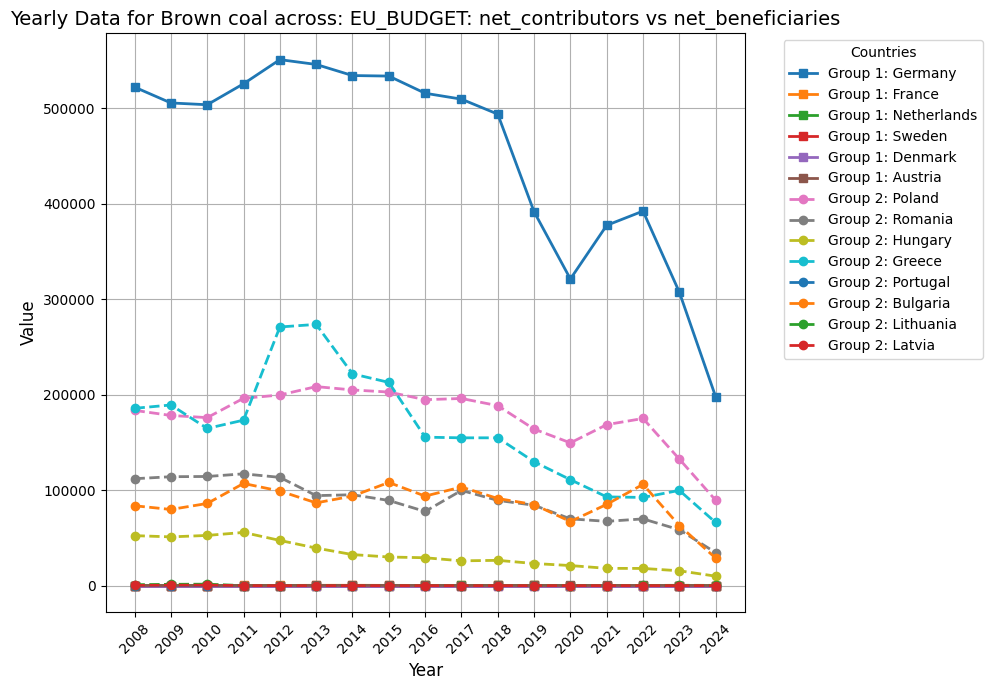

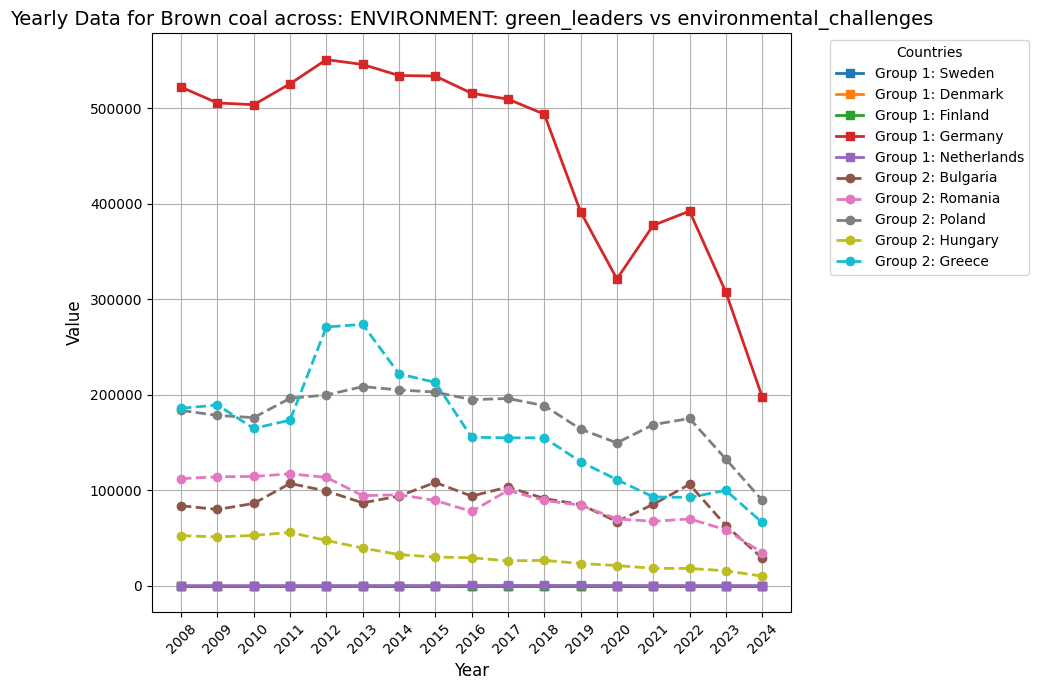

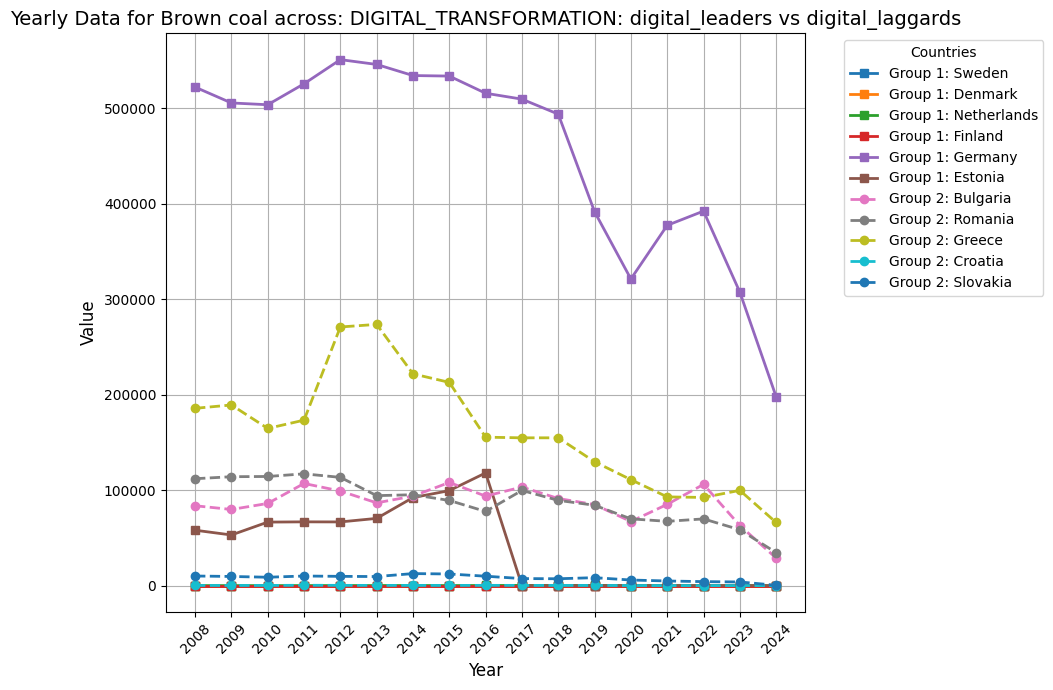

In [14]:
plot_comparison_groups(df_fossil_fuels, 'energy_product', 'Brown coal')

### Dataset 4: Share of energy from renewable sources

**Unit of measure**: Percentage

**Available years in the data**: 2004-2023

**Time**: Annually

**Multi-level index**:

* Country
* Energy balance, either:
    * Renewable energy sources
    * Renewable energy sources in electricity
    * Renewable energy sources in heating and cooling
    * Renewable energy sources in transport

**Available flags**:

* ':' : not available


In [15]:
df_share_of_renewable_sources = eurostat_dataset(NRG_IND_REN)
label_df_share_of_renewable_sources = 'Share of energy from renewable energy sources'
df_share_of_renewable_sources = df_share_of_renewable_sources.rename_axis(index={'Energy balance': 'energy_balance'})
df_share_of_renewable_sources.head(15)

2004  \
Country                energy_balance                                            
Albania                Renewable energy sources                          29.62   
                       Renewable energy sources in electricity          69.979   
                       Renewable energy sources in heating and cooling  33.138   
                       Renewable energy sources in transport             0.099   
Austria                Renewable energy sources                         22.553   
                       Renewable energy sources in electricity          61.627   
                       Renewable energy sources in heating and cooling  20.165   
                       Renewable energy sources in transport             4.532   
Belgium                Renewable energy sources                          1.916   
                       Renewable energy sources in electricity           1.714   
                       Renewable energy sources in heating and cooling   2.927   
                       Renewable energy sources in transport             0.642   
Bosnia and Herzegovina Renewable energy sources                            NaN   
                       Renewable energy sources in electricity             NaN   
                       Renewable energy sources in heating and cooling     NaN   

                                                                          2005  \
Country                energy_balance                                            
Albania                Renewable energy sources                         31.367   
                       Renewable energy sources in electricity          76.112   
                       Renewable energy sources in heating and cooling  37.757   
                       Renewable energy sources in transport             0.095   
Austria                Renewable energy sources                         24.353   
                       Renewable energy sources in electricity          62.901   
                       Renewable energy sources in heating and cooling  22.817   
                       Renewable energy sources in transport             5.070   
Belgium                Renewable energy sources                          2.325   
                       Renewable energy sources in electricity           2.386   
                       Renewable energy sources in heating and cooling   3.418   
                       Renewable energy sources in transport             0.663   
Bosnia and Herzegovina Renewable energy sources                            NaN   
                       Renewable energy sources in electricity             NaN   
                       Renewable energy sources in heating and cooling     NaN   

                                                                          2006  \
Country                energy_balance                                            
Albania                Renewable energy sources                         32.070   
                       Renewable energy sources in electricity          74.208   
                       Renewable energy sources in heating and cooling  30.964   
                       Renewable energy sources in transport             0.000   
Austria                Renewable energy sources                         26.276   
                       Renewable energy sources in electricity          63.527   
                       Renewable energy sources in heating and cooling  24.491   
                       Renewable energy sources in transport             7.532   
Belgium                Renewable energy sources                          2.658   
                       Renewable energy sources in electricity           3.130   
                       Renewable energy sources in heating and cooling   3.812   
                       Renewable energy sources in transport             0.676   
Bosnia and Herzegovina Renewable energy sources                            NaN   
                       Renewable energy sources in ele

### Running Data Analysis for dataset 'Share of energy from renewable energy sources' ###

  Total columns analyzed: 20
  Columns with at least one NaN value: 19 (95.00%); 2004-2020, 2022-2023
  Columns with only NaN values: 0 (0.00%); 
  Columns with at least one 0 value: 20 (100.00%); 2004-2023
  Columns with only 0 values: 0 (0.00%); 
  Columns with >50% NaN values:
  Columns with >50% 0 values:

Timeframe of the dataframe: 2004 to 2023
All years have significant data.
All countries have significant data.

Countries with partially missing years:
  Bosnia and Herzegovina: 2004-2013, 2022-2023
  Euro area – 20 countries (from 2023): 2004-2020
  Georgia: 2004-2020
  Iceland: 2023
  Kosovo*: 2023
  Montenegro: 2004
  Serbia: 2023
All EU countries are in the dataframe.
Non-EU countries in the dataframe: ['Albania', 'Bosnia and Herzegovina', 'Euro area – 20 countries (from 2023)', 'European Union - 27 countries (from 2020)', 'Georgia', 'Iceland', 'Kosovo*', 'Moldova', 'Montenegro', 'North

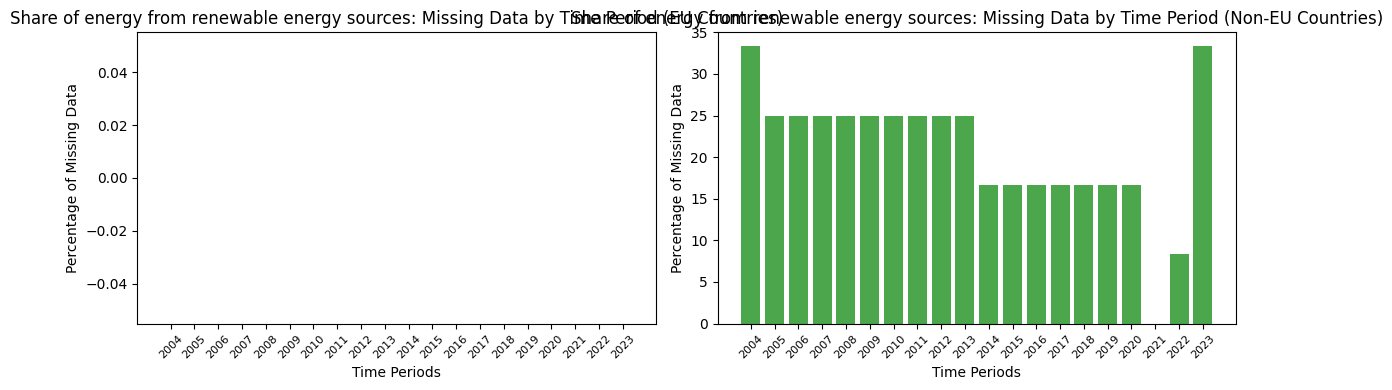

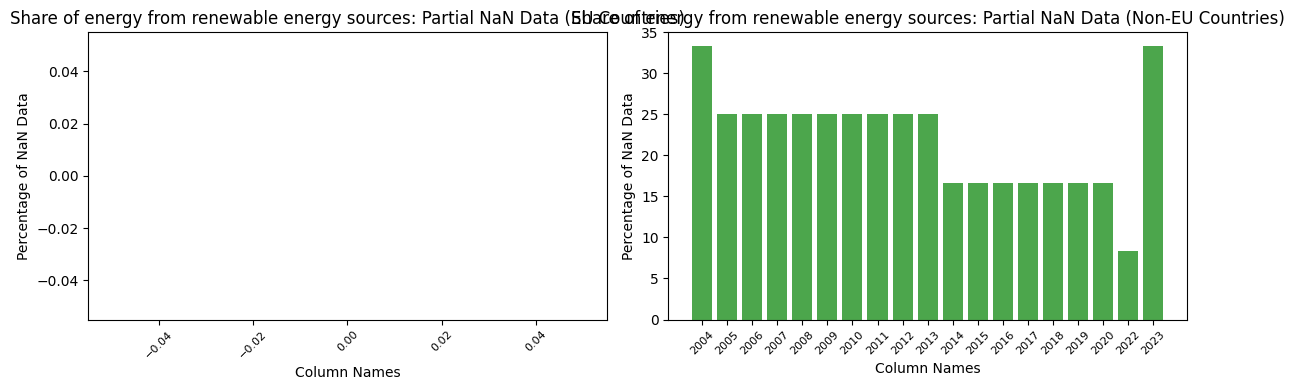

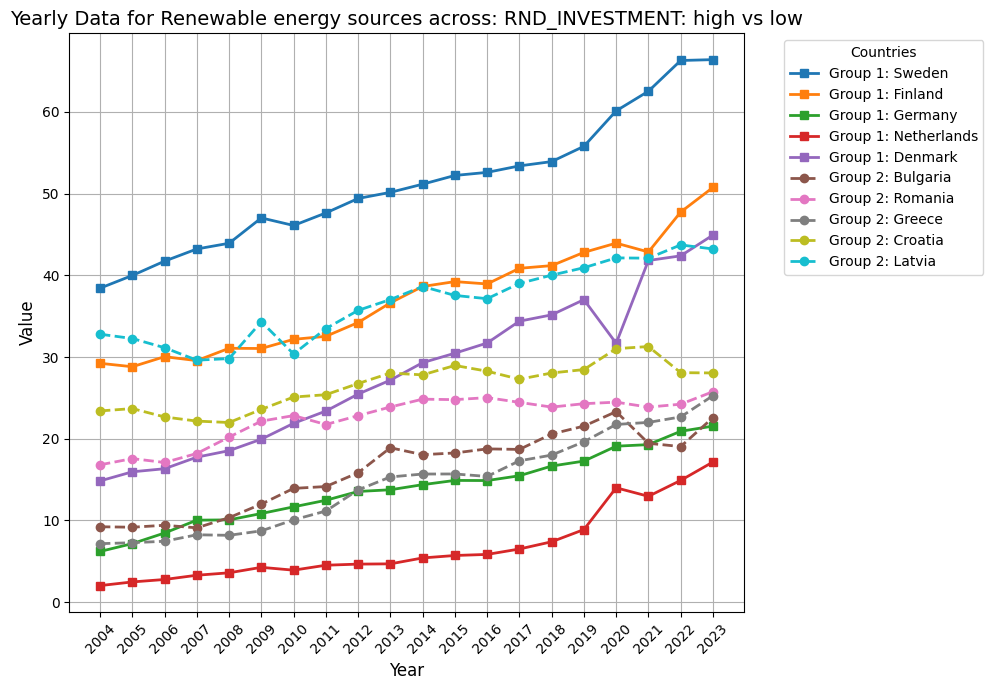

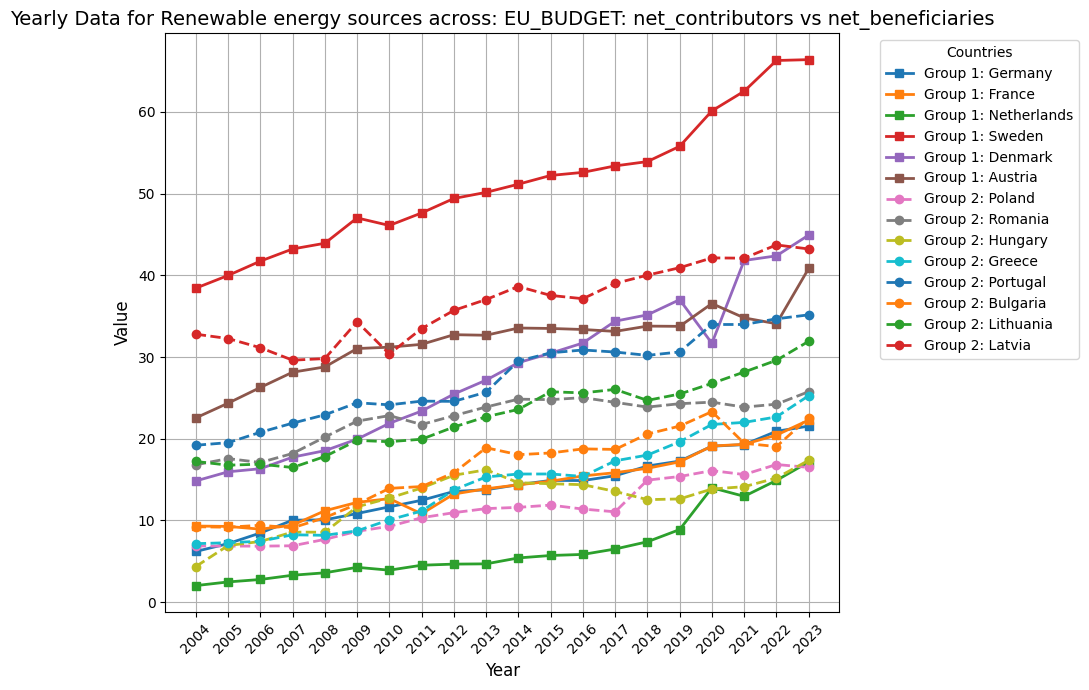

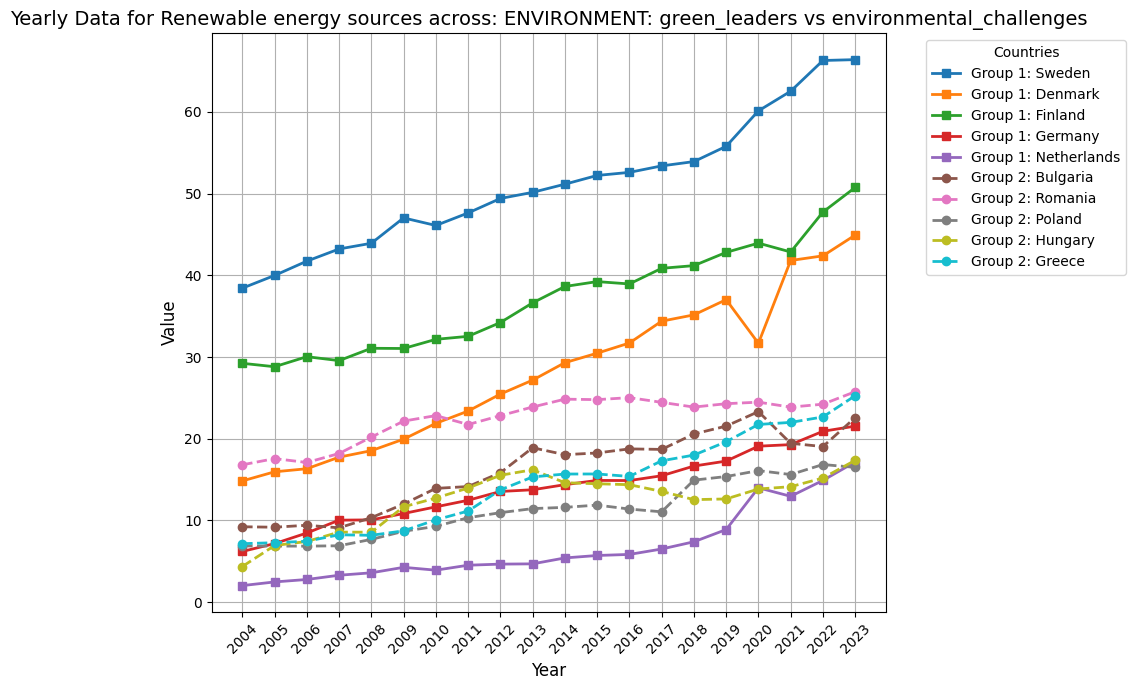

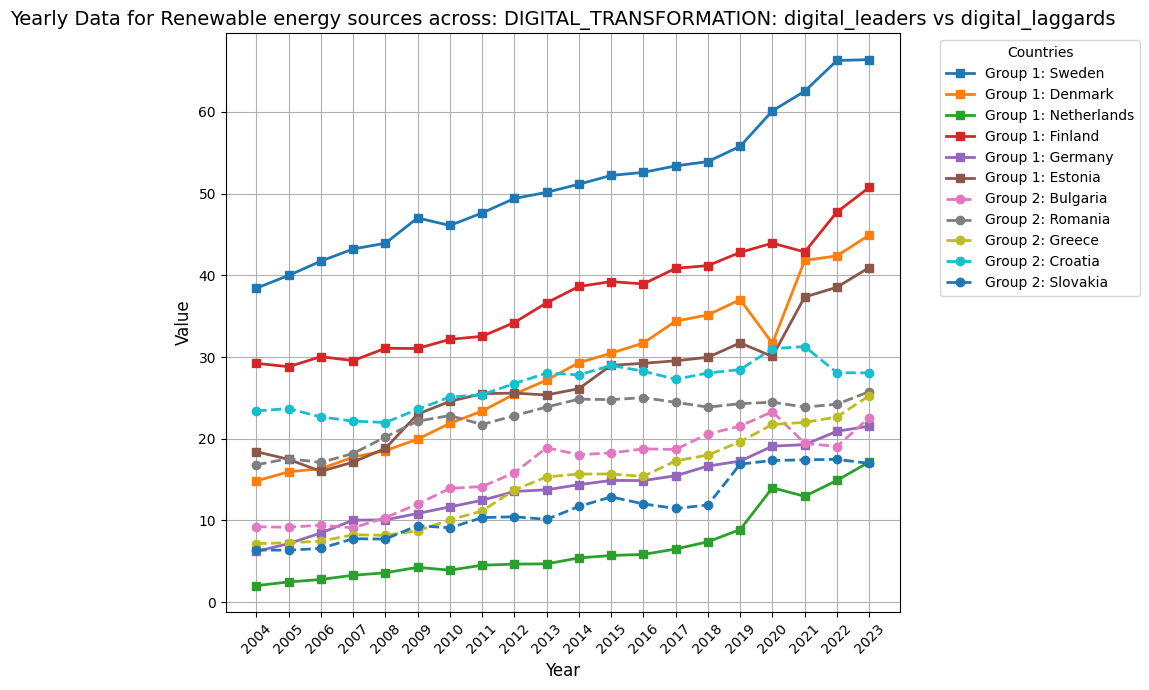

In [16]:
analyze_dataframe(df_share_of_renewable_sources, label_df_share_of_renewable_sources)
plot_comparison_groups(df_share_of_renewable_sources, 'energy_balance', 'Renewable energy sources')

### Dataset 5: Electricity production capacities for renewables and wastes

**Unit of measure**: Megawatt

**Available years in the data**: 1990-2023

**Time**: anually

**Multi-level index**:

* Country

* Energy Product Classification, which can be:
    * Pure hydro power
    * Run-of-river hydro power
    * Mixed hydro power
    * Pumped hydro power
    * Geothermal
    * Wind
    * Wind on shore
    * Wind off shore
    * Solar
    * Solar thermal
    * Solar photovoltaic
    * Solar photovoltaic (< 10 kW)
    * Solar photovoltaic (< 20 kW)
    * Solar photovoltaic (< 30 kW)
    * Solar photovoltaic (< 30 kW, roof top)
    * Solar photovoltaic (< 30 kW, off grid)
    * Solar photovoltaic (20 kW - 1000 kW)
    * Solar photovoltaic (30 kW - 1000 kW)
    * Solar photovoltaic (30 kW - 1000 kW, roof top)
    * Solar photovoltaic (30 kW - 1000 kW, Off grid)
    * Solar photovoltaic (1+ MW)
    * Solar photovoltaic (1+ MW, roof top)
    * Solar photovoltaic (1+ MW, off grid)
    * Solar photovoltaic (off grid)
    * Tide, wave, ocean
    * Solid biofuels
    * Pure biogasoline
    * Pure biodiesels
    * Other liquid biofuels
    * Biogases
    * Waste
    * Industrial waste (non-renewable)
    * Municipal waste

* Technical characteristics of plants, which can be:
    * Net maximum electrical capacity
    * Net maximum electrical capacity - alternating current
    * Net maximum electrical capacity - direct current

**Available flags**:

* ':' : not available

**NOTE**: in this dataset, there is definitely a difference between 0 and NaN!

In general, for this dataset, there are a lot of 0 (probably meaning a 'real' 0), and a lot of NaN's. Especially for the NaN's, which are unlike in the earlier datasets not only for the non-EU countries but also for the EU countries, one should think of a strategy on how to handle those NaNs.  


In [17]:
df_energy_products = eurostat_dataset(NRG_INF_EPCRW)
label_df_energy_products = 'Energy products and technical characteristics of plants by country'
df_energy_products = df_energy_products.rename_axis(index={'Standard international energy product classification (SIEC)': 'energy_product'})
df_energy_products = df_energy_products.rename_axis(index={'Technical characteristics of plants': 'technical_characteristics_of_plants'})
df_energy_products.head(15)

1990  \
Country energy_product                   technical_characteristics_of_plants                        
Albania Biogases                         Net maximum electrical capacity                        0   
                                         Net maximum electrical capacity - alternating c...   NaN   
                                         Net maximum electrical capacity - direct current     NaN   
        Geothermal                       Net maximum electrical capacity                        0   
                                         Net maximum electrical capacity - alternating c...   NaN   
                                         Net maximum electrical capacity - direct current     NaN   
        Hydro                            Net maximum electrical capacity                     1453   
                                         Net maximum electrical capacity - alternating c...   NaN   
                                         Net maximum electrical capacity - direct current     NaN   
        Industrial waste (non-renewable) Net maximum electrical capacity                        0   
                                         Net maximum electrical capacity - alternating c...   NaN   
                                         Net maximum electrical capacity - direct current     NaN   
        Mixed hydro power                Net maximum electrical capacity                        0   
                                         Net maximum electrical capacity - alternating c...   NaN   
                                         Net maximum electrical capacity - direct current     NaN   

                                                                                               1991  \
Country energy_product                   technical_characteristics_of_plants                          
Albania Biogases                         Net maximum electrical capacity                        0.0   
                                         Net maximum electrical capacity - alternating c...     NaN   
                                         Net maximum electrical capacity - direct current       NaN   
        Geothermal                       Net maximum electrical capacity                        0.0   
                                         Net maximum electrical capacity - alternating c...     NaN   
                                         Net maximum electrical capacity - direct current       NaN   
        Hydro                            Net maximum electrical capacity                     1453.0   
                                         Net maximum electrical capacity - alternating c...     NaN   
                                         Net maximum electrical capacity - direct current       NaN   
        Industrial waste (non-renewable) Net maximum electrical capacity                        0.0   
                                         Net maximum electrical capacity - alternating c...     NaN   
                                         Net maximum electrical capacity - direct current       NaN   
        Mixed hydro power                Net maximum electrical capacity                        0.0   
                                         Net maximum electrical capacity - alternating c...     NaN   
                                         Net maximum electrical capacity - direct current       NaN   

                                                                                               1992  \
Country energy_product                   technical_characteristics_of_plants                          
Albania Biogases                         Net maximum electrical capacity                        0.0   
                                         Net maximum electrical capacity - alternating c...     NaN   
                                         Net maximum electrical capacity - direct current       NaN   
        Geothermal                       Net maximum electrical capacity                        0.0   
     

### Running Data Analysis for dataset 'Energy products and technical characteristics of plants by country' ###

  Total columns analyzed: 34
  Columns with at least one NaN value: 34 (100.00%); 1990-2023
  Columns with only NaN values: 0 (0.00%); 
  Columns with at least one 0 value: 34 (100.00%); 1990-2023
  Columns with only 0 values: 0 (0.00%); 
  Columns with >50% NaN values:
    1990: 74.33%
    1991: 74.33%
    1992: 73.69%
    1993: 73.69%
    1994: 73.69%
    1995: 73.69%
    1996: 73.69%
    1997: 73.69%
    1998: 73.69%
    1999: 73.69%
    2000: 73.12%
    2001: 73.12%
    2002: 73.12%
    2003: 73.12%
    2004: 72.34%
    2005: 69.97%
    2006: 69.97%
    2007: 69.33%
    2008: 69.72%
    2009: 68.74%
    2010: 66.51%
    2011: 65.89%
    2012: 65.25%
    2013: 65.07%
    2014: 62.65%
    2015: 62.04%
    2016: 61.40%
    2017: 60.76%
    2018: 59.48%
    2019: 59.53%
    2020: 59.39%
    2021: 56.73%
    2022: 52.39%
    2023: 69.79%
  Columns with >50% 0 values:

Timefram

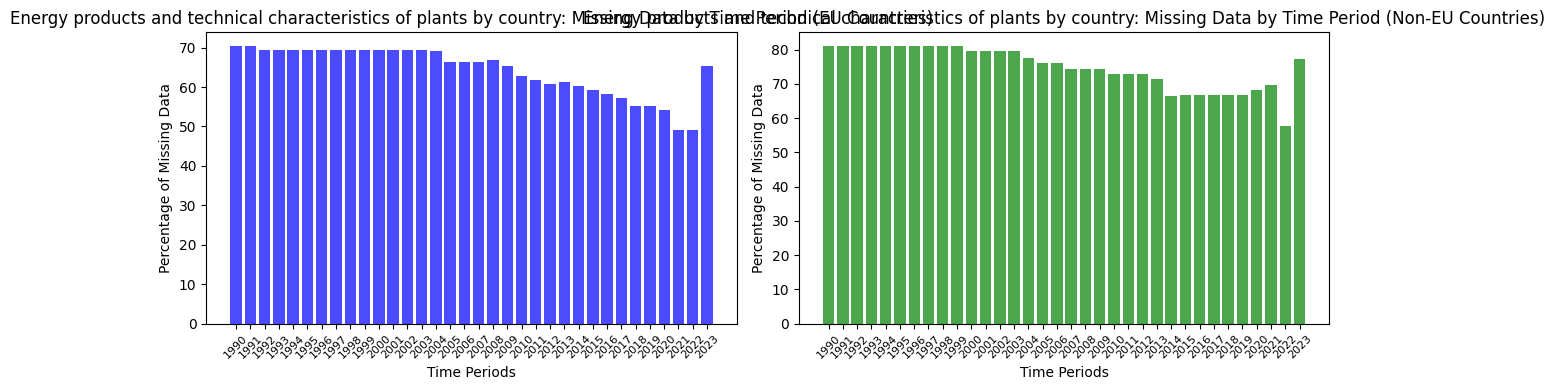

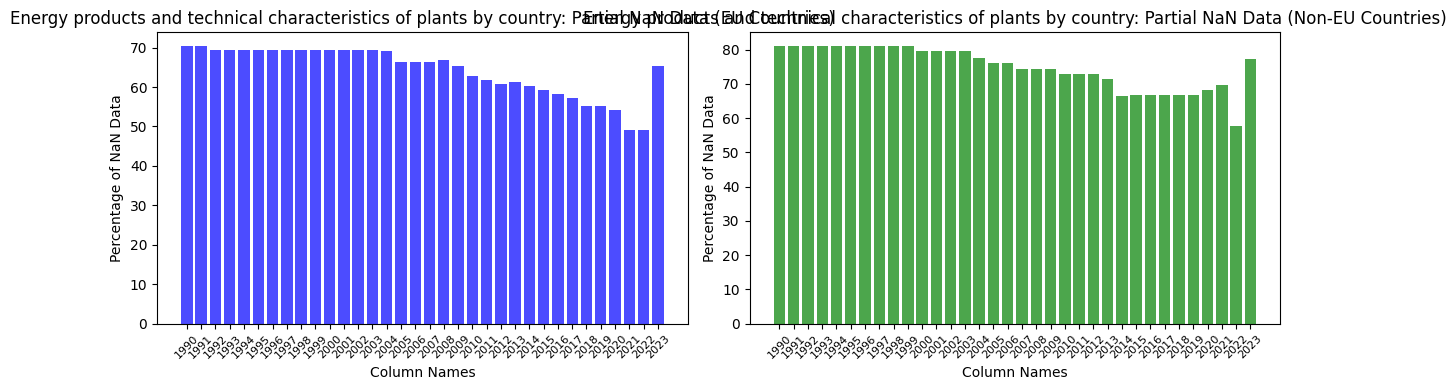

In [18]:
analyze_dataframe(df_energy_products, label_df_energy_products)

### Dataset 6: Electricity prices for household consumers - bi-annual data (from 2007 onwards)

**Unit of measure**: Kilowatt-Hour

**Available years in the data**: 2007 - first half of 2024

**Time**: half-yearly (will be aggregated to annually)

**Multi-level index**:

* Country
* energy_consumption, which can be:
    * Consumption of kWh - all bands
    * Consumption less than 1 000 kWh - band DA
    * Consumption from 1 000 kWh to 2 499 kWh - band DB
    * Consumption from 2 500 kWh to 4 999 kWh - band DC
    * Consumption from 5 000 kWh to 14 999 kWh - band DD
    * Consumption for 15 000 kWh or over - band DE
* taxes, which can be:
    * Excluding taxes and levies
    * All taxes and levies included
    * Excluding VAT and other recoverable taxes and levies
* currency, which can be:
    * Euro
    * Purchasing Power Standard
    * National currency

**Available flags**:

* ':' : not available

In [19]:
df_electricity_prices_semesterly = eurostat_dataset(NRG_PC_204)
df_electricity_prices_semesterly = df_electricity_prices_semesterly.rename_axis(index={'Energy consumption': 'energy_consumption'})
df_electricity_prices_semesterly = df_electricity_prices_semesterly.rename_axis(index={'Taxes': 'taxes'})
df_electricity_prices_semesterly = df_electricity_prices_semesterly.rename_axis(index={'Currency': 'currency'})
df_electricity_prices_semesterly = df_electricity_prices_semesterly.reset_index().drop(columns=['Products']).set_index(['Country', 'energy_consumption', 'taxes', 'currency'])
df_electricity_prices = transform_df_from_semesterly_to_yearly(df_electricity_prices_semesterly)
label_df_electricity_prices = 'Electricity prices by country'
df_electricity_prices.head(15)

2007  \
Country energy_consumption                                taxes                                              currency                         
Albania Consumption for 15 000 kWh or over - band DE      All taxes and levies included                      Euro                         0   
                                                                                                             National currency            0   
                                                                                                             Purchasing Power Standard    0   
                                                          Excluding VAT and other recoverable taxes and l... Euro                         0   
                                                                                                             National currency            0   
                                                                                                             Purchasing Power Standard    0   
                                                          Excluding taxes and levies                         Euro                         0   
                                                                                                             National currency            0   
                                                                                                             Purchasing Power Standard    0   
        Consumption from 1 000 kWh to 2 499 kWh - band DB All taxes and levies included                      Euro                         0   
                                                                                                             National currency            0   
                                                                                                             Purchasing Power Standard    0   
                                                          Excluding VAT and other recoverable taxes and l... Euro                         0   
                                                                                                             National currency            0   
                                                                                                             Purchasing Power Standard    0   

                                                                                                                                        2008  \
Country energy_consumption                                taxes                                              currency                          
Albania Consumption for 15 000 kWh or over - band DE      All taxes and levies included                      Euro                        0.0   
                                                                                                             National currency           0.0   
                                                                                                             Purchasing Power Standard   0.0   
                                                          Excluding VAT and other recoverable taxes and l... Euro                        0.0   
                                                                                                             National currency           0.0   
                                                                                                             Purchasing Power Standard   0.0   
                                                          Excluding taxes and levies                         Euro                        0.0   
                                                                                                             National currency           0.0   
                                                                                                             Purchasing Power Standard   0.0   
        Consumption from 1 000 kWh to 2 499 kWh - band DB All taxes and levies included                      Euro      

### Running Data Analysis for dataset 'Electricity prices by country' ###

  Total columns analyzed: 18
  Columns with at least one NaN value: 0 (0.00%); 
  Columns with only NaN values: 0 (0.00%); 
  Columns with at least one 0 value: 18 (100.00%); 2007-2024
  Columns with only 0 values: 0 (0.00%); 
  Columns with >50% NaN values:
  Columns with >50% 0 values:

Timeframe of the dataframe: 2007 to 2024
All years have significant data.
All countries have significant data.

Countries with partially missing years:
  Albania: 2007-2010
  Bosnia and Herzegovina: 2007-2009
  Georgia: 2007-2017
  Iceland: 2007-2011
  Italy: 2007
  Kosovo*: 2007-2012
  Liechtenstein: 2007-2013
  Moldova: 2007-2014
  Montenegro: 2007-2010
  North Macedonia: 2007-2011
  Serbia: 2007-2012
  Ukraine: 2007-2015, 2022-2024
  United Kingdom: 2021-2024
All EU countries are in the dataframe.
Non-EU countries in the dataframe: ['Albania', 'Bosnia and Herzegovina', 'Euro area (EA11-1999, EA12-2001, EA13-2007, EA15-2008, 

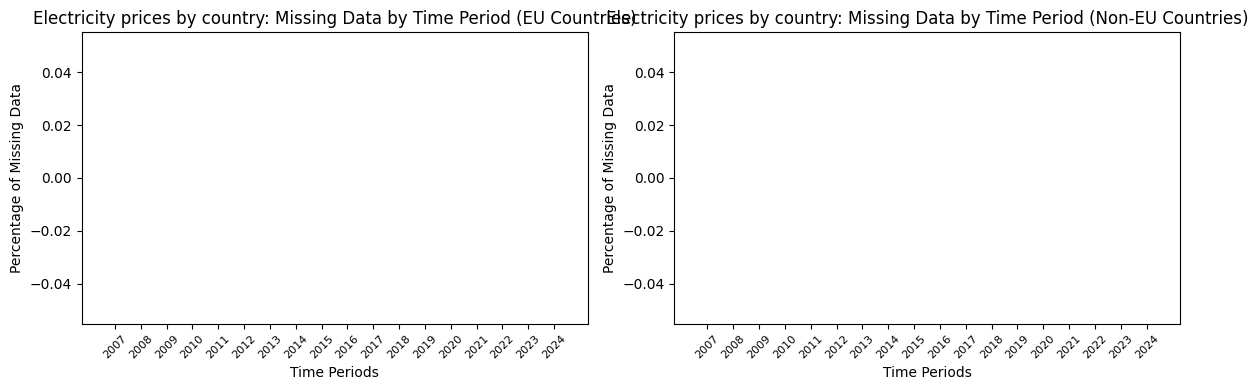

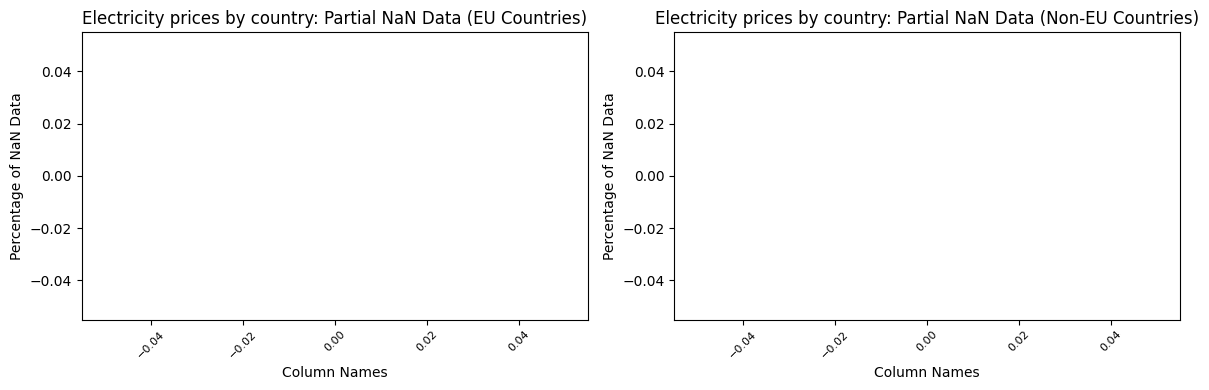

In [20]:
analyze_dataframe(df_electricity_prices, label_df_electricity_prices)

### Dataset 7: Gross domestic product at market prices

**Unit of measure**: Current prices, euro per capita

**Available years in the data**: 2012-2023

**Time**: annually

**Index**:

* Country

**Available flags**:

* ':' : not available
* b : break in time series
* e : estimated
* p : provisional

In [21]:
df_gdp_at_markt_prices = eurostat_dataset(TEC00001)
label_df_gdp_at_markt_prices = 'GDP at markt prices'
df_gdp_at_markt_prices = df_gdp_at_markt_prices.reset_index().drop(columns=['National accounts indicator (ESA 2010)']).set_index(['Country'])
df_gdp_at_markt_prices.head(15)

2012     2013     2014     2015  \
Country                                                                       
Albania                                     3300   3320.0   3450.0   3560.0   
Austria                                    37570  37890.0  38640.0  39640.0   
Belgium                                    34930  35360.0  36130.0  36860.0   
Bosnia and Herzegovina                       NaN      NaN      NaN      NaN   
Bulgaria                                    5820   5870.0   6080.0   6560.0   
Croatia                                    10510  10530.0  10450.0  10810.0   
Cyprus                                     22570  20930.0  20510.0  21220.0   
Czechia                                    15590  15280.0  15140.0  16230.0   
Denmark                                    45490  46240.0  47070.0  47900.0   
Estonia                                    13650  14520.0  15480.0  16000.0   
Euro area - 19 countries  (2015-2022)      29470  29730.0  30400.0  31370.0   
Euro area – 20 countries (from 2023)       29230  29490.0  30150.0  31120.0   
European Union - 27 countries (from 2020)  25980  26250.0  26830.0  27770.0   
Finland                                    37010  37410.0  37690.0  38350.0   
France                                     31950  32280.0  32620.0  33200.0   

                                              2016     2017     2018     2019  \
Country                                                                         
Albania                                     3730.0   4020.0   4480.0   4880.0   
Austria                                    40690.0  41760.0  43360.0  44570.0   
Belgium                                    37810.0  38980.0  40210.0  41730.0   
Bosnia and Herzegovina                         NaN      NaN      NaN      NaN   
Bulgaria                                    7070.0   7720.0   8360.0   9270.0   
Croatia                                    11400.0  12160.0  12960.0  13990.0   
Cyprus                                     22330.0  23630.0  25060.0  26530.0   
Czechia                                    17040.0  18700.0  20270.0  21740.0   
Denmark                                    49270.0  51060.0  51950.0  53040.0   
Estonia                                    16860.0  18480.0  20040.0  21490.0   
Euro area - 19 countries  (2015-2022)      32130.0  33260.0  34270.0  35310.0   
Euro area – 20 countries (from 2023)       31870.0  33010.0  34020.0  35060.0   
European Union - 27 countries (from 2020)  28460.0  29600.0  30580.0  31630.0   
Finland                                    39250.0  40790.0  42040.0  43200.0   
France                                     33530.0  34290.0  35080.0  36090.0   

                                              2020     2021     2022     2023  
Country                                                                        
Albania                                     4710.0   5420.0   6500.0      NaN  
Austria                                    42650.0  45380.0  49490.0  51830.0  
Belgium                                    40190.0  43670.0  48250.0  50620.0  
Bosnia and Herzegovina                         NaN      NaN      NaN      NaN  
Bulgaria                                    9450.0  10970.0  13310.0  14690.0  
Croatia                                    12840.0  14890.0  17260.0  19800.0  
Cyprus                                     25080.0  28520.0  32230.0  33800.0  
Czechia                                    20980.0  23430.0  26670.0  29180.0  
Denmark                                    53540.0  58970.0  64730.0  63290.0  
Estonia                                    20960.0  23650.0  27360.0  27960.0  
Euro area - 19 countries  (2015-2022)      33740.0  36610.0  39630.0  41860.0  
Euro area – 20 countries (from 2023)       33500.0  36360.0  39380.0  41610.0  
European Union - 27 countries (from 2020)  30440.0  33180.0  35980.0  38130.0  
Finland                                    42740.0  44890.0  47890.0  49000.0  
France                                    

### Running Data Analysis for dataset 'GDP at markt prices' ###

  Total columns analyzed: 12
  Columns with at least one NaN value: 12 (100.00%); 2012-2023
  Columns with only NaN values: 0 (0.00%); 
  Columns with at least one 0 value: 0 (0.00%); 
  Columns with only 0 values: 0 (0.00%); 
  Columns with >50% NaN values:
  Columns with >50% 0 values:

Timeframe of the dataframe: 2012 to 2023
All years have significant data.
Countries with near-zero values in all years: ['Bosnia and Herzegovina', 'Kosovo*']

Countries with partially missing years:
  Albania: 2023
  Liechtenstein: 2012, 2023
  United Kingdom: 2020-2023
All EU countries are in the dataframe.
Non-EU countries in the dataframe: ['Albania', 'Bosnia and Herzegovina', 'Euro area - 19 countries  (2015-2022)', 'Euro area – 20 countries (from 2023)', 'European Union - 27 countries (from 2020)', 'Iceland', 'Kosovo*', 'Liechtenstein', 'Montenegro', 'North Macedonia', 'Norway', 'Serbia', 'Switzerland', 'Türkiye', 'United Kingdom']


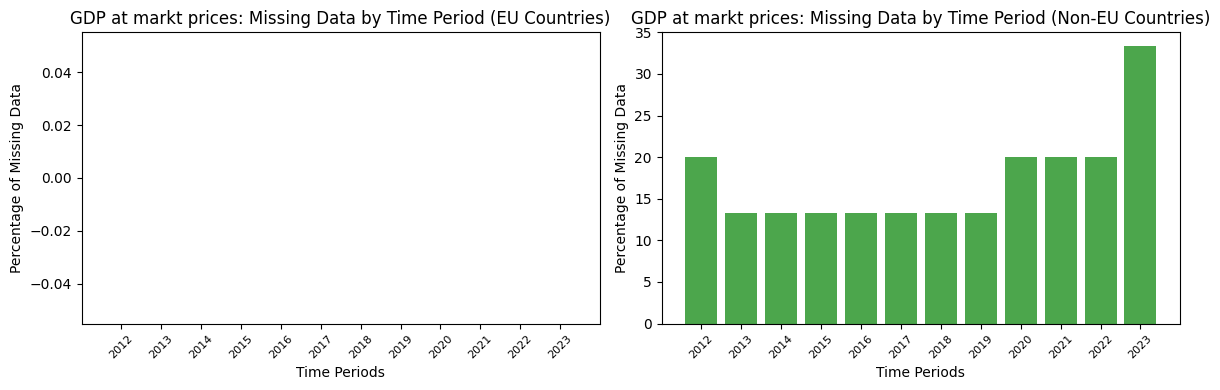

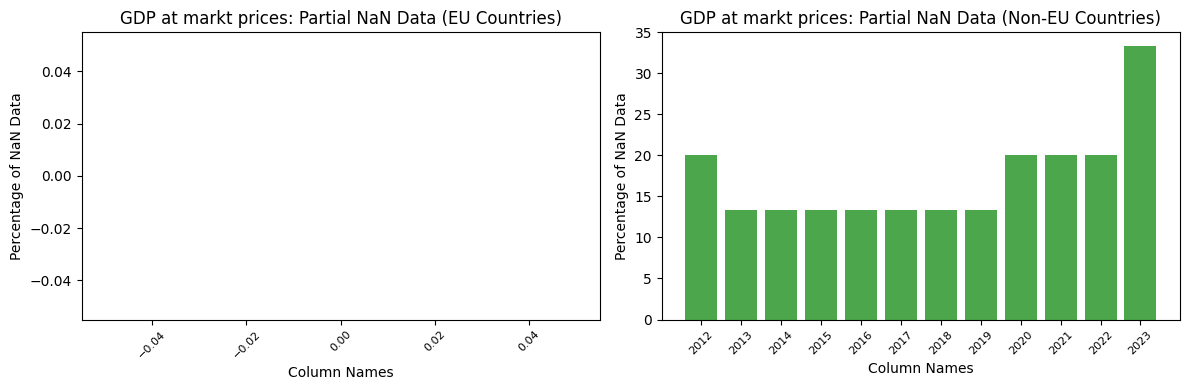

In [22]:
analyze_dataframe(df_gdp_at_markt_prices, label_df_gdp_at_markt_prices)

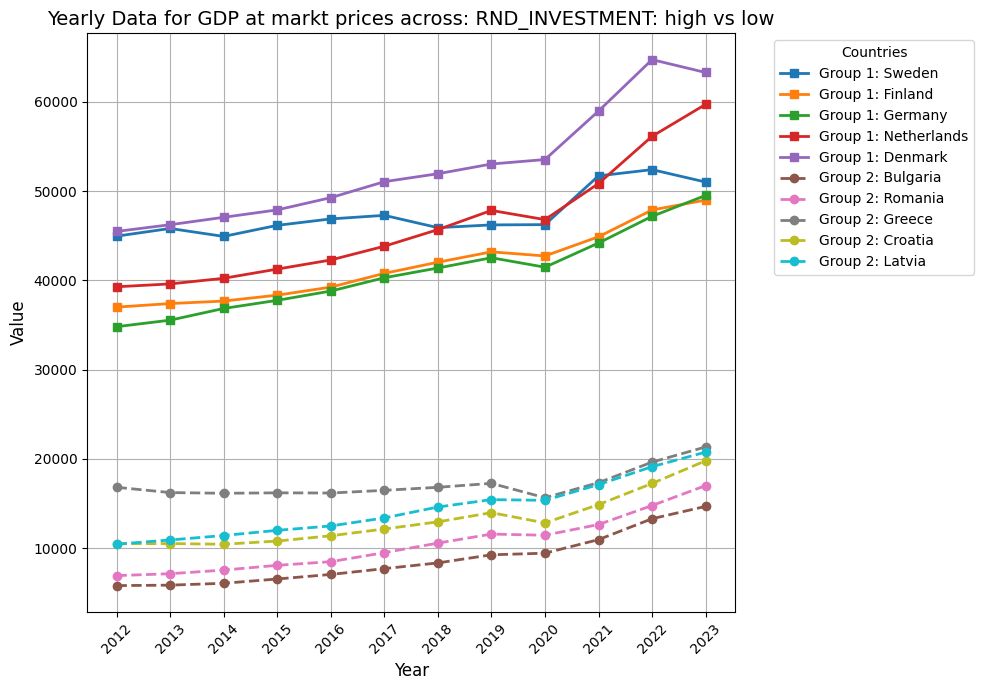

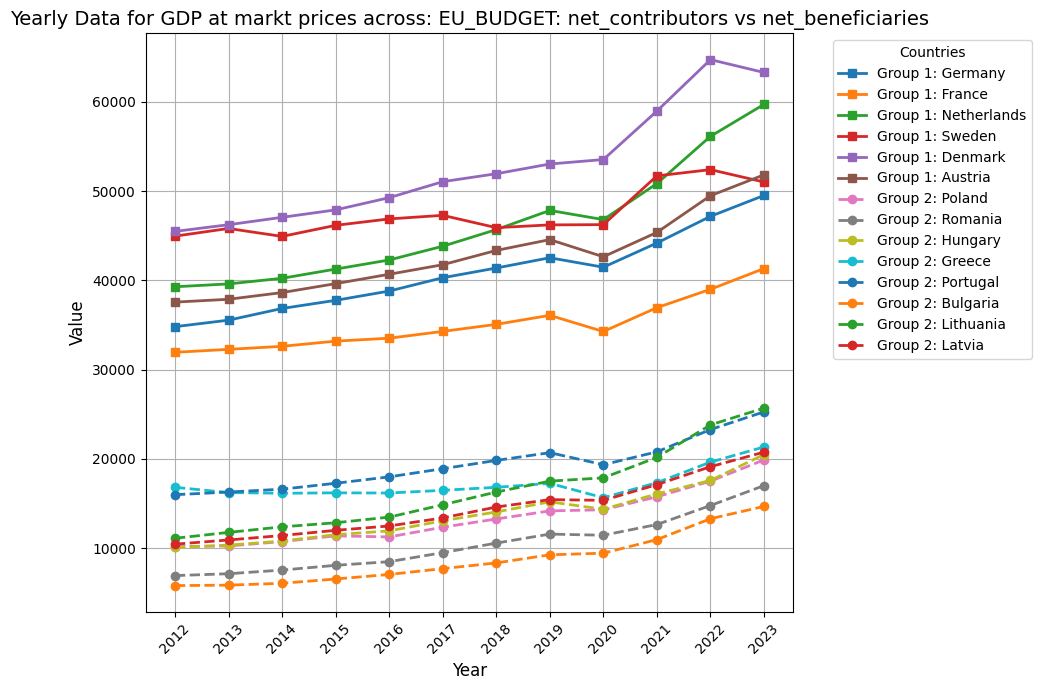

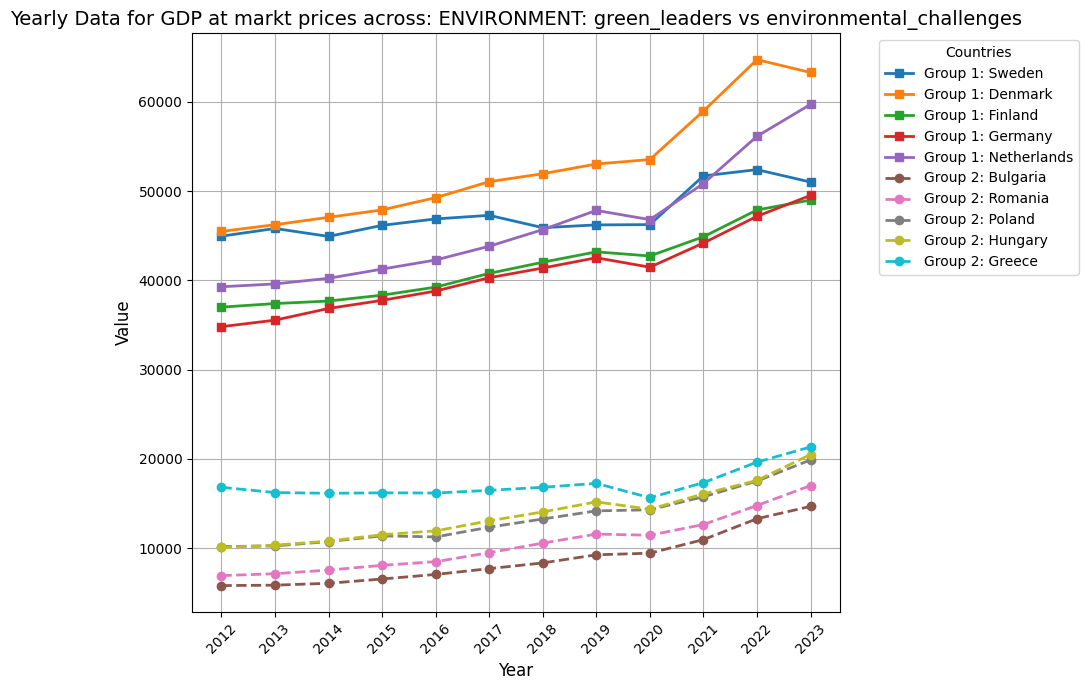

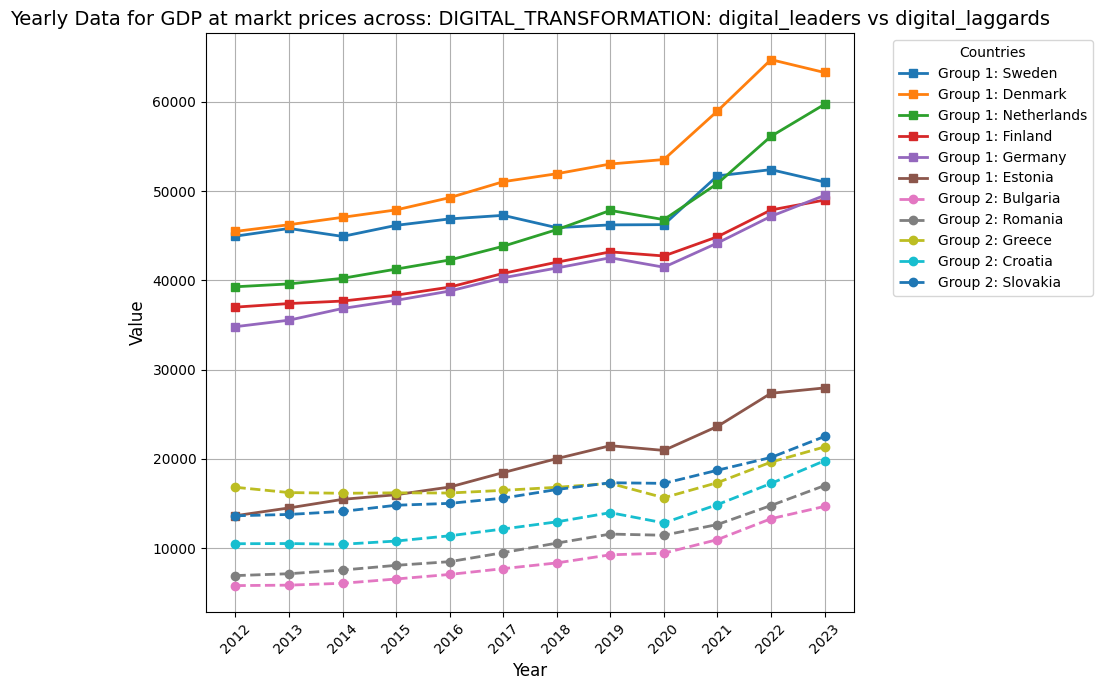

In [23]:
plot_comparison_groups(df_gdp_at_markt_prices, None, 'GDP at markt prices')

## Question 1: How is the adoption of renewable energy in Europe evolving?

In [24]:
energy_share = eurostat_dataset(NRG_IND_REN)

#### The idea is to track a ranking of all EU countries based on the renewable energy adaption over the past years. This way we have an overall metric which provides uns with a good starting point for later clustering, based on these scores and ranks. 
We will calculate the raking of the countries as below, we will calculate three mentrics namely (i) the latest renewable energy shares in percent (ii) the annual average growth and (iii) the standard deviation in order to capture volatitility over the history trend. We then calculate the overall score by perfoming a weighted addition of these three mentrics and then normalize them over the whole dataset in order to make these scores comparable over all EU countries. For simplicity we created a level mentric ranging from 0-10 for easier understanding

In [25]:
# filter out non-EU countries
energy_share = energy_share.loc[energy_share.index.get_level_values(0).isin(EU_COUNTRIES)]


# normalize % values of renewable energy shares
tmp = energy_share.copy() / 100
growth = tmp.apply(lambda row: (row.iloc[-1] - row.iloc[0]) / len(row), axis=1) # avg growth per year
latest = tmp.iloc[:, -1] # latest shares
volatility = tmp.diff(axis=1).std(axis=1)

performance = pd.DataFrame({"latest": latest, "growth": growth, "volatility": volatility})

# normalize per each "energy balance" to calculate overall performance score
def normalize_per_sector(group):
    scaler = MinMaxScaler()
    return pd.DataFrame(scaler.fit_transform(group), index=group.index, columns=group.columns)

performance = performance.groupby(level=1, group_keys=False).apply(normalize_per_sector)

performance["score"] = (
    0.5 * performance["latest"] + 
    0.4 * performance["growth"] +
    0.1 * performance["volatility"] * (performance["growth"] > 0.05).astype(float)
)

performance["level"] = pd.qcut(performance["score"], 10, labels=range(1, 11), duplicates="drop").astype(float)
performance

latest    growth  \
Country Energy balance                                                        
Austria Renewable energy sources                         0.533556  0.536384   
        Renewable energy sources in electricity          1.000000  0.376023   
        Renewable energy sources in heating and cooling  0.532463  0.343378   
        Renewable energy sources in transport            0.375481  0.336058   
Belgium Renewable energy sources                         0.056998  0.321500   
...                                                           ...       ...   
Spain   Renewable energy sources in transport            0.337377  0.416021   
Sweden  Renewable energy sources                         1.000000  0.916735   
        Renewable energy sources in electricity          0.997183  0.592060   
        Renewable energy sources in heating and cooling  1.000000  0.389626   
        Renewable energy sources in transport            1.000000  1.000000   

                                                         volatility     score  \
Country Energy balance                                                          
Austria Renewable energy sources                           0.594255  0.540757   
        Renewable energy sources in electricity            1.000000  0.750409   
        Renewable energy sources in heating and cooling    0.653015  0.468884   
        Renewable energy sources in transport              0.062017  0.328366   
Belgium Renewable energy sources                           0.063250  0.163424   
...                                                             ...       ...   
Spain   Renewable energy sources in transport              0.162041  0.351301   
Sweden  Renewable energy sources                           0.346313  0.901325   
        Renewable energy sources in electricity            0.652753  0.800691   
        Renewable energy sources in heating and cooling    0.467275  0.702578   
        Renewable energy sources in transport              0.216047  0.921605   

                                                         level  
Country Energy balance                                          
Austria Renewable energy sources                           8.0  
        Renewable energy sources in electricity           10.0  
        Renewable energy sources in heating and cooling    8.0  
        Renewable energy sources in transport              6.0  
Belgium Renewable energy sources                           2.0  
...                                                        ...  
Spain   Renewable energy sources in transport              7.0  
Sweden  Renewable energy sources                          10.0  
        Renewable energy sources in electricity           10.0  
        Renewable energy sources in heating and cooling   10.0  
        Renewable energy sources in transport             10.0  

[108 rows x 5 columns]

In order to verify the plausability of this ranking we compared went throught the Wikipeida pages about renewable energy for these countries and accepted this ranking as our basis for further research. Luxemburg shows the worst EU ranking, which was unexpected at first. However after reading about their energy balances the ranking seems to be reasonable due to its high usage of coal and fossil fuel for electricity and import of electricity from outside according to Wikipedia. Funfact: Czechia, Ireland and Louxemburg are the only countries that have no "renewable energy entry"  wikipedia page.

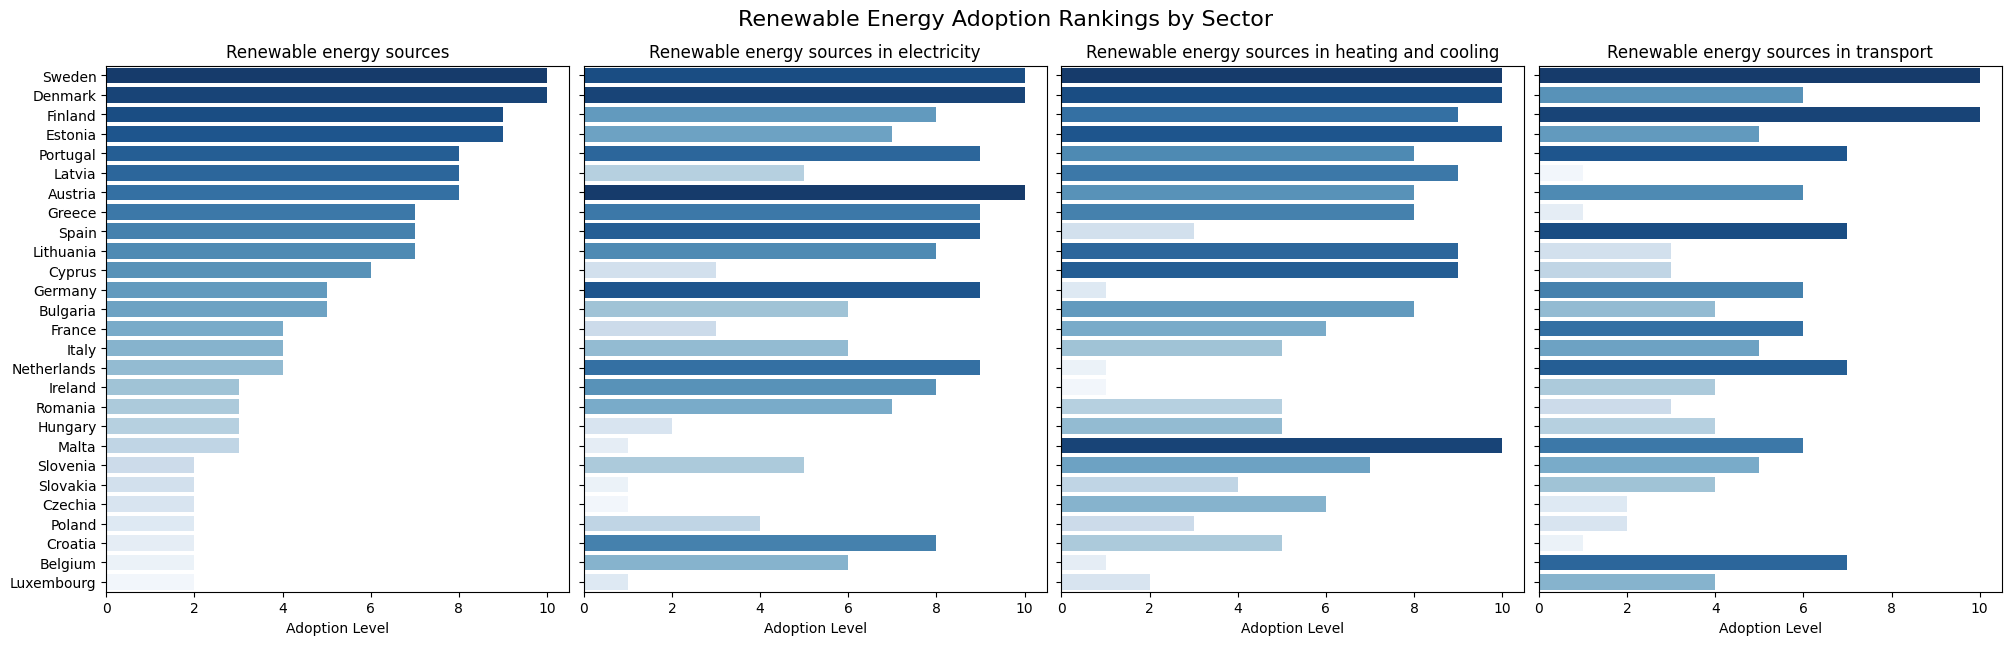

In [26]:
fig, axes = plt.subplots(1, 4, figsize=(20, 6), sharey=True, constrained_layout=True)
levels = performance['level'].unstack(level=1)

for idx, sector in enumerate(levels.columns):
    sector_ranking = levels[sector].sort_values(ascending=False)
    sns.barplot(
        x=sector_ranking.values, 
        y=sector_ranking.index, 
        palette="Blues_r",
        hue=sector_ranking.index,
        ax=axes[idx]
    )

    axes[idx].set_title(sector, fontsize=12)
    axes[idx].set_xlabel("Adoption Level")
    axes[idx].set_ylabel("")

fig.suptitle("Renewable Energy Adoption Rankings by Sector", fontsize=16, y=1.05)
plt.show()

In [27]:
levels = performance['level'].unstack(level=1)
sector_ranking = levels.reset_index().melt(id_vars="Country", var_name="Sector", value_name="Level")
sector_ranking = sector_ranking[sector_ranking["Level"] > 7]

fig = px.choropleth(
    sector_ranking,
    locations="Country",
    locationmode="country names",
    color="Sector",
    projection="natural earth",
    scope="europe",
    title="Countries with Renewable Energy Adoption Level > 7",
    color_discrete_sequence=px.colors.qualitative.Set1
)

fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})
fig.show()

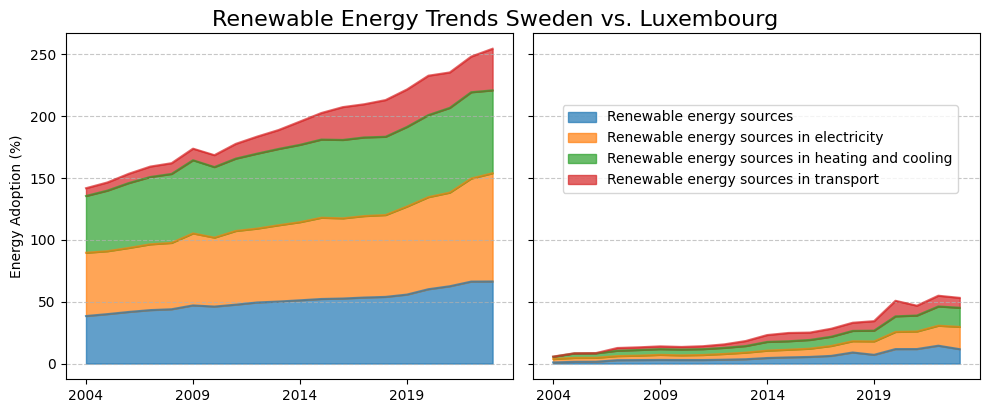

In [28]:
# compare highest vs lowest rank countries
countries_to_compare = ("Sweden", "Luxembourg")
comparison_data = energy_share.loc[energy_share.index.get_level_values(0).isin(countries_to_compare)]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4), sharex=True, sharey=True)
axes = axes.flatten()

for idx, country in enumerate(countries_to_compare):
    country_data = comparison_data.loc[country]
    
    country_data.T.plot(kind='area', stacked=True, alpha=0.7, ax=axes[idx], legend=False)
    
    axes[idx].set_ylabel("Energy Adoption (%)", fontsize=10)
    axes[idx].grid(axis='y', linestyle='--', alpha=0.7)

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor=(0.97, 0.8), fontsize=10)

plt.tight_layout()
plt.suptitle("Renewable Energy Trends Sweden vs. Luxembourg", fontsize=16, y=1.02)
plt.show()

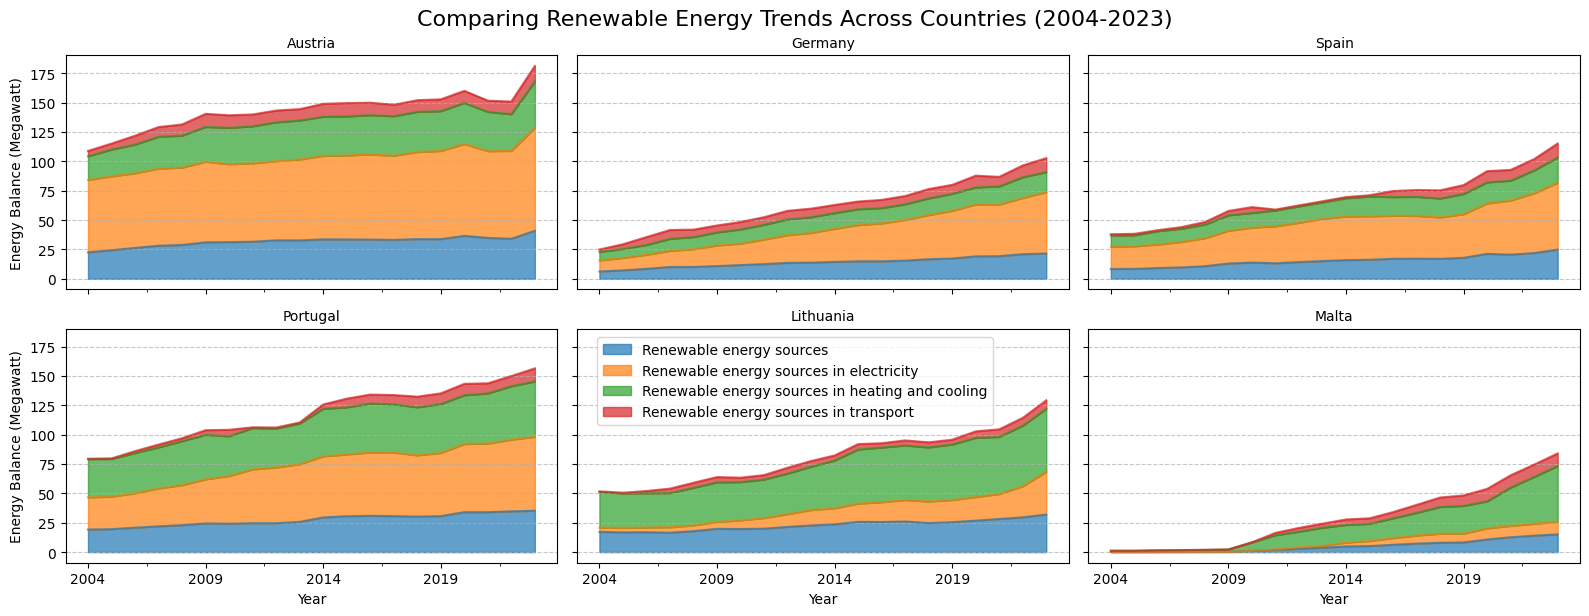

In [29]:
# Select an interested subset of countries based on our ranking
countries_to_compare = ("Austria", "Germany", "Spain", "Portugal", "Lithuania", "Malta")
comparison_data = energy_share.loc[energy_share.index.get_level_values('Country').isin(countries_to_compare)]

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(16, 6), sharex=True, sharey=True)
axes = axes.flatten()

for idx, country in enumerate(countries_to_compare):
    country_data = comparison_data.loc[country]
    
    country_data.T.plot(kind='area', stacked=True, alpha=0.7, ax=axes[idx], legend=False)
    
    axes[idx].set_title(country, fontsize=10)
    axes[idx].set_xlabel("Year", fontsize=10)
    axes[idx].set_ylabel("Energy Balance (Megawatt)", fontsize=10)
    axes[idx].grid(axis='y', linestyle='--', alpha=0.7)

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="center", bbox_to_anchor=(0.5, 0.4), ncol=1, fontsize=10)

plt.tight_layout()
plt.suptitle("Comparing Renewable Energy Trends Across Countries (2004-2023)", fontsize=16, y=1.02)
plt.show()

In [30]:
melted_data = energy_share.reset_index().melt(id_vars=["Country", "Energy balance"], var_name="Year", value_name="Energy Balance")

renewable_data = melted_data[melted_data["Energy balance"] == "Renewable energy sources"].copy()
renewable_data["Year"] = renewable_data["Year"]
renewable_data["Energy Balance"] = renewable_data["Energy Balance"].infer_objects()

fig = px.choropleth(
    renewable_data,
    range_color=(renewable_data['Energy Balance'].min(), renewable_data['Energy Balance'].max()),
    locations="Country",
    locationmode="country names",
    color="Energy Balance",
    projection="natural earth",
    hover_name="Country",
    animation_frame="Year",
    # title="Renewable Energy Trends Across the EU (2004-2023)",
    scope="europe"
)

fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

## Question 2: How is the adoption of different types of renewable energy evolving?

In [37]:
energy_types = eurostat_dataset(NRG_INF_EPCRW)
# we will only focus on the net maximum electrical capacity for now
energy_types = energy_types.xs('Net maximum electrical capacity', level=2)
energy_types

1990  \
Country        Standard international energy product classific...         
Albania        Biogases                                               0   
               Geothermal                                             0   
               Hydro                                               1453   
               Industrial waste (non-renewable)                       0   
               Mixed hydro power                                      0   
...                                                                 ...   
United Kingdom Tide, wave, ocean                                      0   
               Waste                                                 31   
               Wind                                                  10   
               Wind off shore                                         0   
               Wind on shore                                          0   

                                                                     1991  \
Country        Standard international energy product classific...           
Albania        Biogases                                               0.0   
               Geothermal                                             0.0   
               Hydro                                               1453.0   
               Industrial waste (non-renewable)                       0.0   
               Mixed hydro power                                      0.0   
...                                                                   ...   
United Kingdom Tide, wave, ocean                                      0.0   
               Waste                                                 31.0   
               Wind                                                  14.0   
               Wind off shore                                         0.0   
               Wind on shore                                          0.0   

                                                                     1992  \
Country        Standard international energy product classific...           
Albania        Biogases                                               0.0   
               Geothermal                                             0.0   
               Hydro                                               1453.0   
               Industrial waste (non-renewable)                       0.0   
               Mixed hydro power                                      0.0   
...                                                                   ...   
United Kingdom Tide, wave, ocean                                      0.0   
               Waste                                                 45.0   
               Wind                                                  50.0   
               Wind off shore                                         0.0   
               Wind on shore                                          0.0   

                                                                     1993  \
Country        Standard international energy product classific...           
Albania        Biogases                                               0.0   
               Geothermal                                             0.0   
               Hydro                                               1453.0   
               Industrial waste (non-renewable)                       0.0   
               Mixed hydro power                                      0.0   
...                                                                   ...   
United Kingdom Tide, wave, ocean                                      0.0   
               Waste                                                 50.0   
               Wind                                                 131.0   
               Wind off shore                                         0.0   
               Wind on shore                                          0.0   

                                                                     1994  \
Country 

In [40]:
energy_types.index.get_level_values(1).unique()

Index(['Biogases', 'Geothermal', 'Hydro', 'Industrial waste (non-renewable)',
       'Mixed hydro power', 'Municipal waste', 'Other liquid biofuels',
       'Pumped hydro power', 'Pure biodiesels', 'Pure biogasoline',
       'Pure hydro power', 'Run-of-river hydro power', 'Solar',
       'Solar photovoltaic', 'Solar photovoltaic (1+ MW)',
       'Solar photovoltaic (1+ MW, off grid)',
       'Solar photovoltaic (1+ MW, roof top)',
       'Solar photovoltaic (20 kW - 1000 kW)',
       'Solar photovoltaic (30 kW - 1000 kW)',
       'Solar photovoltaic (30 kW - 1000 kW, Off grid)',
       'Solar photovoltaic (30 kW - 1000 kW, roof top)',
       'Solar photovoltaic (< 10 kW)', 'Solar photovoltaic (< 20 kW)',
       'Solar photovoltaic (< 30 kW)',
       'Solar photovoltaic (< 30 kW, off grid)',
       'Solar photovoltaic (< 30 kW, roof top)',
       'Solar photovoltaic (off grid)', 'Solar thermal', 'Solid biofuels',
       'Tide, wave, ocean', 'Waste', 'Wind', 'Wind off shore',
       'Win

In [49]:
# in order to reduce complexity we will focus on energy type goups
siec_groups = {
    'solar': ['Solar photovoltaic', 'Solar photovoltaic (1+ MW)', 'Solar photovoltaic (1+ MW, off grid)',
              'Solar photovoltaic (1+ MW, roof top)', 'Solar photovoltaic (20 kW - 1000 kW)',
              'Solar photovoltaic (30 kW - 1000 kW)', 'Solar photovoltaic (30 kW - 1000 kW, Off grid)',
              'Solar photovoltaic (30 kW - 1000 kW, roof top)', 'Solar photovoltaic (< 10 kW)',
              'Solar photovoltaic (< 20 kW)', 'Solar photovoltaic (< 30 kW)',
              'Solar photovoltaic (< 30 kW, off grid)', 'Solar photovoltaic (< 30 kW, roof top)',
              'Solar photovoltaic (off grid)', 'Solar thermal', 'GeothermalSolar'],
    'wind': ['Wind', 'Wind off shore', 'Wind on shore'],
    'hydro': ['Hydro', 'Pure hydro power', 'Pumped hydro power', 'Run-of-river hydro power', 'Mixed hydro power'],
    'biomass': ['Biogases', 'Pure biodiesels', 'Pure biogasoline', 'Other liquid biofuels', 'Solid biofuels'],
    'waste': ['Municipal waste', 'Industrial waste (non-renewable)', 'Waste'],
    'water': ['Tide, wave, ocean'],
}

In [56]:
def map_siec_category(siec_name):
    for category, sources in siec_groups.items():
        if siec_name in sources:
            return category

# apply the mapping
megawatt_df_grouped = energy_types.reset_index()
megawatt_df_grouped['Energy Category'] = megawatt_df_grouped['Standard international energy product classification (SIEC)'].apply(map_siec_category)
del megawatt_df_grouped['Standard international energy product classification (SIEC)']

# summing up by country and new category
grouped_capacity = megawatt_df_grouped.groupby(['Country', 'Energy Category']).sum()
grouped_capacity

1990    1991    1992    1993    1994    1995  \
Country        Energy Category                                                 
Albania        biomass             0     0.0     0.0     0.0     0.0     0.0   
               hydro            2906  2906.0  2906.0  2906.0  2906.0  2906.0   
               solar               0     0.0     0.0     0.0     0.0     0.0   
               waste               0     0.0     0.0     0.0     0.0     0.0   
               water               0     0.0     0.0     0.0     0.0     0.0   
...                              ...     ...     ...     ...     ...     ...   
United Kingdom hydro            7794  8404.0  8420.0  8424.0  8426.0  8440.0   
               solar               0     0.0     0.0     0.0     0.0     0.0   
               waste              62    62.0    90.0   100.0   174.0   174.0   
               water               0     0.0     0.0     0.0     0.0     0.0   
               wind               10    14.0    50.0   131.0   153.0   200.0   

                                  1996    1997    1998    1999  ...  \
Country        Energy Category                                  ...   
Albania        biomass             0.0     0.0     0.0     0.0  ...   
               hydro            2906.0  2906.0  2906.0  2906.0  ...   
               solar               0.0     0.0     0.0     0.0  ...   
               waste               0.0     0.0     0.0     0.0  ...   
               water               0.0     0.0     0.0     0.0  ...   
...                                ...     ...     ...     ...  ...   
United Kingdom hydro            8486.0  8552.0  8526.0  8530.0  ...   
               solar               0.0     1.0     1.0     1.0  ...   
               waste             230.0   230.0   324.0   322.0  ...   
               water               0.0     0.0     0.0     0.0  ...   
               wind              238.0   322.0   331.0   357.0  ...   

                                     2014       2015       2016       2017  \
Country        Energy Category                                               
Albania        biomass              0.000      0.000      0.000      0.000   
               hydro             3450.000   3596.000   3826.000   4094.000   
               solar                0.000      0.000      0.000      2.000   
               waste                0.000      0.000      0.000      0.000   
               water                0.000      0.000      0.000      0.000   
...                                   ...        ...        ...        ...   
United Kingdom hydro             9013.000   9533.948   9574.000  10078.912   
               solar            11056.000  19202.437  23828.000  25520.000   
               waste             1360.000   1859.880   2056.570   2181.866   
               water                9.000      8.938      8.938     13.487   
               wind             26147.906  28611.268  32251.870  39169.996   

                                     2018       2019    2020    2021     2022  \
Country        Energy Category                                                  
Albania        biomass              0.000      0.000     0.0     0.0     0.00   
               hydro             4210.000   4324.000  4774.0  5014.0  7479.00   
               solar                2.000     28.000    42.0    46.0   272.28   
               waste                0.000      0.000     0.0     0.0     0.00   
               water                0.000      0.000     0.0     0.0     0.00   
...                                   ...        ...     ...     ...      ...   
United Kingdom hydro             9783.000   9786.000     0.0     0.0     0.00   
               solar            26146.000  26692.000     0.0     0.0     0.00   
               waste             2273.454   2642.868     0.0     0.0     0.00   
               water               18.398     20.398     0.0     0.0     0.00   
               wind             43534.442  48190.762     0.0     0.0     0.00   

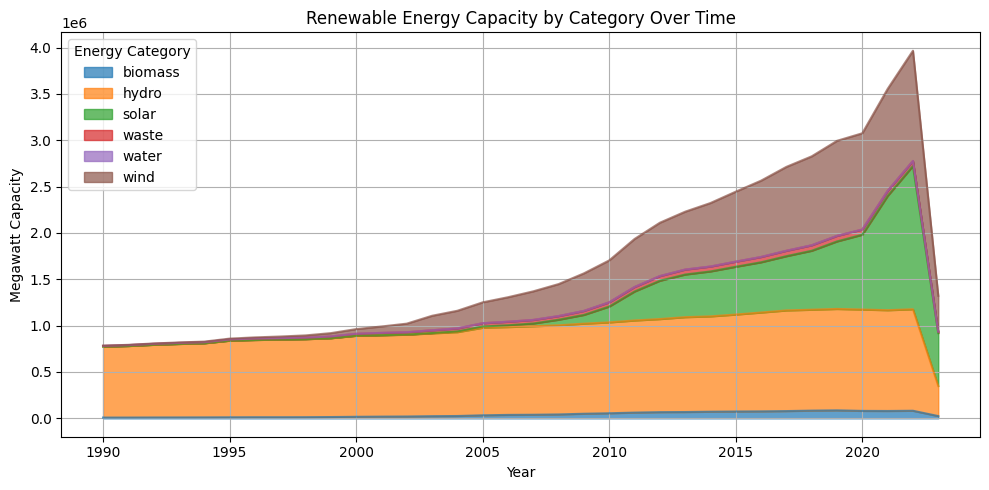

In [109]:
import matplotlib.pyplot as plt

# we observe a huge increase in wind, water, solar energy.
# hydro capacity stayed overall same
# interestingly the capacities peaked in 2022 and decreased in 2023
energy_trends = grouped_capacity.groupby('Energy Category').sum()
energy_trends.T.plot(figsize=(10,5), title="Renewable Energy Capacity by Category Over Time", kind='area', alpha=0.7, grid=True)
plt.xlabel("Year")
plt.ylabel("Megawatt Capacity")
plt.tight_layout()
plt.legend(title="Energy Category")
plt.show()


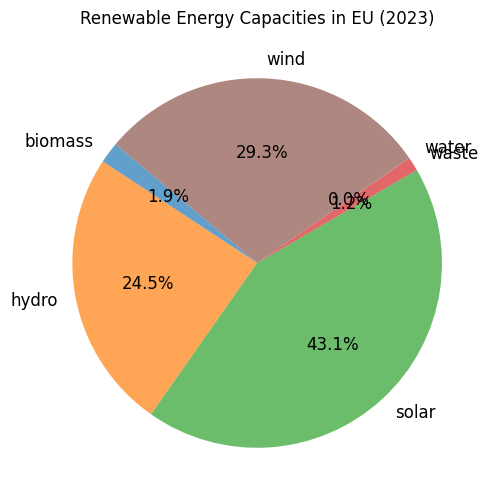

In [81]:
last_year = energy_trends.columns.max()
last_year_capacity = grouped_capacity[last_year].reset_index()
category_totals = last_year_capacity.groupby('Energy Category').sum()[last_year]

# create a pie chart
plt.figure(figsize=(10, 6))
wedges, texts, autotexts = plt.pie(
    category_totals, labels=category_totals.index, autopct='%1.1f%%', startangle=140,
    wedgeprops={'alpha': 0.7}, textprops={'fontsize': 12}
)

plt.title(f"Renewable Energy Capacities in EU ({last_year})")
plt.show()


In [103]:
# correlation of each energy type's capacity with performance scores
energy_types = grouped_capacity.index.get_level_values(1).unique()
scores = performance.xs("Renewable energy sources", level=1)

correlations = {}
for energy in energy_types:
    sub_df = grouped_capacity.xs(energy, level=1).sum(axis=1)
    sub_df.name = energy
    merged_df = pd.concat([scores, sub_df], axis=1).dropna()
    correlations[energy] = merged_df.corr().iloc[0,1]

# convert to DataFrame and display
correlation_df = pd.DataFrame.from_dict(correlations, orient='index', columns=['Correlation'])
print(correlation_df.sort_values(by='Correlation', ascending=False))

energy_capacity_df = grouped_capacity.groupby(level=1).sum().T
print(energy_capacity_df.corr())


         Correlation
biomass     0.662202
hydro       0.662202
solar       0.662202
waste       0.662202
water       0.662202
wind        0.662202
Energy Category   biomass     hydro     solar     waste     water      wind
Energy Category                                                            
biomass          1.000000  0.765421  0.811060  0.974367 -0.072280  0.969566
hydro            0.765421  1.000000  0.474608  0.815260  0.507639  0.681937
solar            0.811060  0.474608  1.000000  0.699555 -0.233138  0.915837
waste            0.974367  0.815260  0.699555  1.000000 -0.045258  0.910975
water           -0.072280  0.507639 -0.233138 -0.045258  1.000000 -0.150034
wind             0.969566  0.681937  0.915837  0.910975 -0.150034  1.000000


In [102]:
# compute total capacity per country
total_capacity = grouped_capacity.groupby(level=0).sum().sum(axis=1)

# merge with performance scores
merged_df = pd.concat([scores, total_capacity], axis=1).dropna()

# compute correlation
overall_correlation = merged_df.corr().iloc[0, 1]
print(f"Correlation of total capacity with score: {overall_correlation}")

Correlation of total capacity with score: 0.6622015627990248


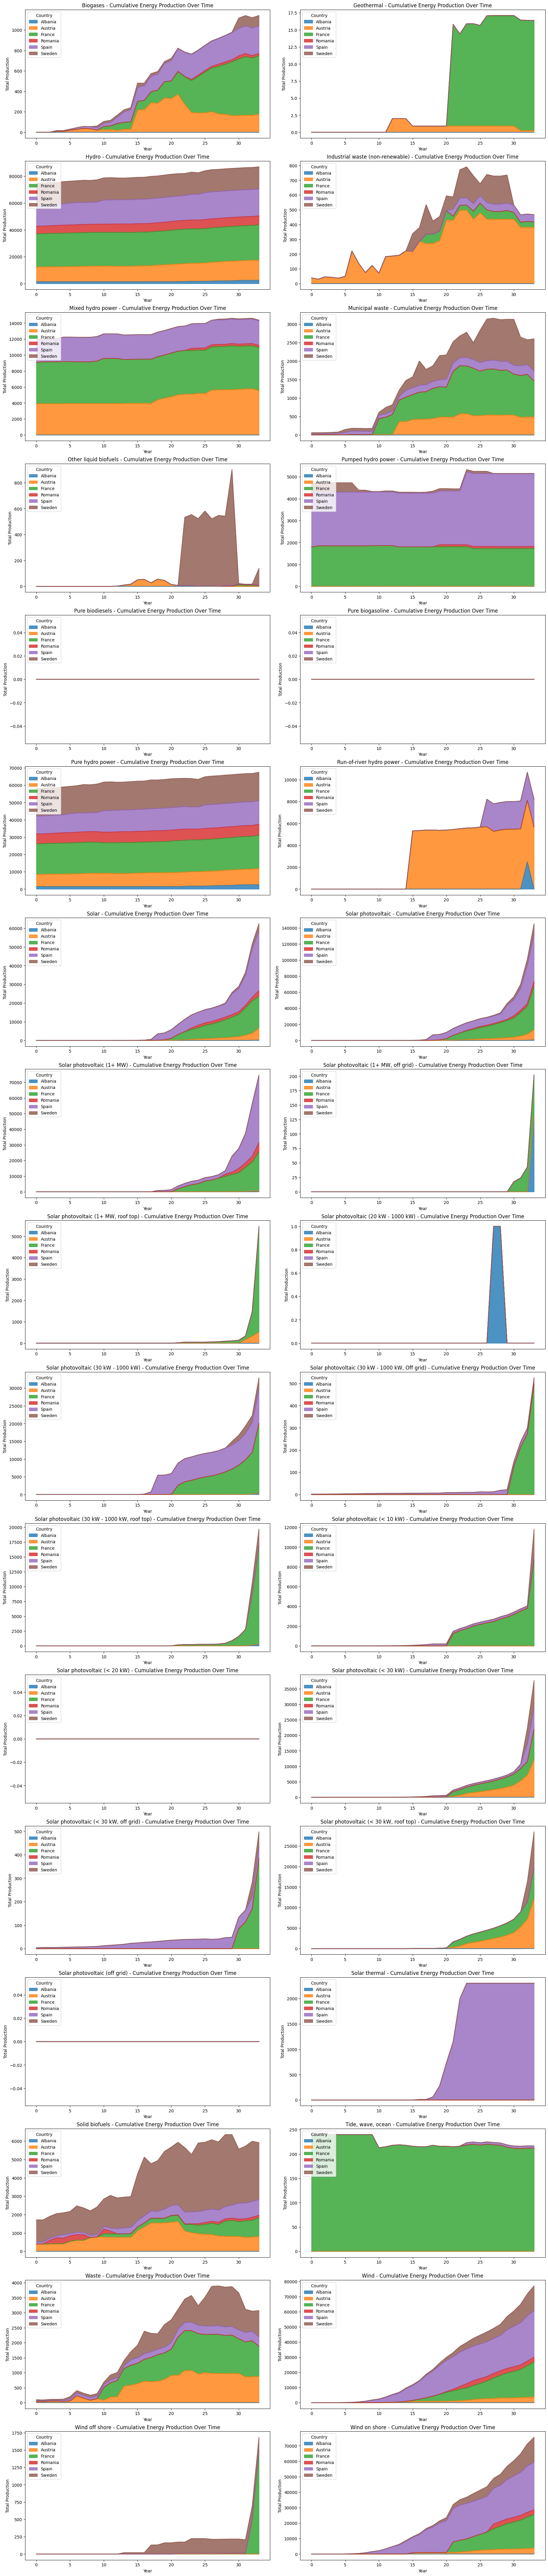

In [107]:
import math

countries_to_compare = ("Sweden", "Spain", "Austria", "Albania", "France", "Romania")
comparison_data = energy_types.loc[energy_types.index.get_level_values('Country').isin(countries_to_compare)]
grouped = comparison_data.groupby(['Standard international energy product classification (SIEC)', 'Country']).sum()
distinct_siec_values = grouped.index.get_level_values("Standard international energy product classification (SIEC)").unique()

num_siec = len(distinct_siec_values)
cols = 2
rows = math.ceil(num_siec / cols)


fig, axes = plt.subplots(rows, cols, figsize=(18, rows * 5), constrained_layout=True)
axes = axes.flatten()

# plot each energy type in a separate subplot
for idx, siec_type in enumerate(distinct_siec_values):
    filtered_df = grouped[grouped.index.get_level_values("Standard international energy product classification (SIEC)") == siec_type]
    df_reset = filtered_df.reset_index()
    
    grouped_by_country = df_reset.groupby("Country").sum()
    grouped_by_country = grouped_by_country.drop("Standard international energy product classification (SIEC)", axis=1)
    
    yearly_totals_by_country = grouped_by_country.T
    yearly_totals_by_country = yearly_totals_by_country.reset_index()
    yearly_totals_by_country.rename(columns={"index": "Year"}, inplace=True)
    ax = axes[idx]
    yearly_totals_by_country.plot.area(ax=ax, alpha=0.8)
    
    ax.set_title(f"{siec_type} - Cumulative Energy Production Over Time", fontsize=12)
    ax.set_xlabel("Year")
    ax.set_ylabel("Total Production")
    ax.legend(title="Country", loc='upper left', fontsize=10)

# Hide any empty subplots (if applicable)
for idx in range(len(distinct_siec_values), len(axes)):
    fig.delaxes(axes[idx])

plt.show()


## Question 3: Are there characteristics of countries that correlate with their level of adoption of renewable energy?

Are there any correlation between renewable energy type adaption and the geogrpahy of a country? Surely, but considering only the data we have is not enough, as seen below, we will need more demogrpahic data about mountains, seas, etc..

In [124]:
# aggregate energy capacities by country and energy category
energy_by_country = last_year_capacity.groupby(['Country', 'Energy Category']).sum().reset_index()
energy_by_country = energy_by_country.dropna(subset=[last_year])
energy_by_country = energy_by_country[energy_by_country[last_year] > 0]  # Remove zero values

# Find the dominant renewable energy type per country
# Fix: Use idxmax() correctly to find the highest energy capacity per country
dominant_energy = energy_by_country.loc[energy_by_country.groupby('Country')[last_year].idxmax()]

# Create a choropleth map
fig = px.choropleth(
    dominant_energy,
    locations="Country",
    locationmode="country names",
    color="Energy Category",  # Color-coded by dominant energy type
    projection="natural earth",
    scope="europe",
    title="Dominant Renewable Energy Type per Country (2023)",
    color_discrete_sequence=px.colors.qualitative.Set1
)

# Show the map
fig.show()

In [126]:
energy_by_country[energy_by_country['Country'] == 'Austria']

Country Energy Category       2023
6   Austria         biomass    983.315
7   Austria           hydro  35566.942
8   Austria           solar  19148.066
9   Austria           waste   1743.480
11  Austria            wind   7792.588

How about GDP and education, do these factors maybe correlate to the country ranking of renewable energy?

In [178]:
gdp = eurostat_dataset(TEC00001)
gdp = gdp[gdp.columns.max()].reset_index() # get data of latest year
gdp = gdp[gdp['Country'].isin(EU_COUNTRIES)] # filter out non-eu
gdp.set_index('Country', inplace=True)
# normalize gdp
gdp = gdp_series = pd.Series(MinMaxScaler().fit_transform(gdp[['2023']].values).flatten(), index=gdp.index, name="GDP")
gdp.head(5)

Country
Austria     0.356841
Belgium     0.345215
Bulgaria    0.000000
Croatia     0.049097
Cyprus      0.183609
Name: GDP, dtype: float64

In [183]:
education = eurostat_dataset(EDAT_LFSE_03)
education = education[education.columns.max()].reset_index() # get data of latest year
education = education[education['Country'].isin(EU_COUNTRIES)] # filter out non-eu
education = education[(education['Sex'] == 'Total') & (education['Age class'] == 'From 15 to 64 years')] # ignore gender
education.set_index('Country', inplace=True)
education = education.pivot_table(
    index=['Country'],
    columns='International Standard Classification of Education (ISCED 2011)', 
    values='2023'
)

In [189]:
features = education.join(gdp, how='left')
features = features.join(scores['score'], how='left')

rename_dict = {
    "Less than primary, primary and lower secondary education (levels 0-2)": "Low Education (%)",
    "Tertiary education (levels 5-8)": "Tertiary Education (%)",
    "Upper secondary and post-secondary non-tertiary education (levels 3 and 4)": "Secondary Education (%)",
    "Upper secondary and post-secondary non-tertiary education (levels 3 and 4) - general": "General Secondary (%)",
    "Upper secondary and post-secondary non-tertiary education (levels 3 and 4) - vocational": "Vocational Secondary (%)",
    "Upper secondary, post-secondary non-tertiary and tertiary education (levels 3-8)": "Higher Education (%)"
}

# Apply renaming to the DataFrame
features = features.rename(columns=rename_dict)


features

Low Education (%)  Tertiary Education (%)  \
Country                                                  
Austria                   18.5                    33.6   
Belgium                   22.5                    39.1   
Bulgaria                  18.7                    26.7   
Croatia                   15.2                    24.9   
Cyprus                    17.7                    46.0   
Czechia                   13.4                    23.5   
Denmark                   25.6                    35.5   
Estonia                   17.5                    36.0   
Finland                   18.5                    35.7   
France                    21.1                    37.6   
Germany                   23.1                    29.0   
Greece                    22.4                    29.9   
Hungary                   18.1                    25.8   
Ireland                   17.4                    46.6   
Italy                     36.7                    19.2   
Latvia                    16.0                    34.0   
Lithuania                 11.6                    41.0   
Luxembourg                23.7                    45.7   
Malta                     29.6                    30.8   
Netherlands               23.6                    38.4   
Poland                    12.0                    33.2   
Portugal                  41.1                    27.1   
Romania                   22.3                    16.1   
Slovakia                  12.8                    25.8   
Slovenia                  16.4                    29.8   
Spain                     37.7                    37.1   
Sweden                    19.2                    41.9   

             Secondary Education (%)  General Secondary (%)  \
Country                                                       
Austria                         47.9                    7.5   
Belgium                         38.4                   13.9   
Bulgaria                        54.6                   26.2   
Croatia                         60.0                    5.4   
Cyprus                          36.3                   24.9   
Czechia                         63.1                    6.2   
Denmark                         38.9                   12.0   
Estonia                         46.5                   18.7   
Finland                         45.8                   10.9   
France                          41.3                   12.6   
Germany                         47.8                    7.0   
Greece                          47.8                   30.6   
Hungary                         56.1                   14.4   
Ireland                         36.0                   22.6   
Italy                           44.1                   12.5   
Latvia                          50.0                   23.2   
Lithuania                       47.5                   19.7   
Luxembourg                      30.6                    NaN   
Malta                           39.7                   23.0   
Netherlands                     38.0                   11.2   
Poland                          54.8                   12.1   
Portugal                        31.8                   20.1   
Romania                         61.6                    8.6   
Slovakia                        61.5                    5.6   
Slovenia                        53.8                    5.9   
Spain                           25.2                   15.6   
Sweden                          38.9                   16.5   

             Vocational Secondary (%)  Higher Education (%)       GDP  \
Country                                                                 
Austria                          40.4                  81.5  0.356841   
Belgium                          24.4                  77.5  0.345215   
Bulgaria                         28.4                  81.3  0.000000   
Croatia                          54.6                  84.8  0.049097   
Cyprus                           11.4                  82.3  0.1

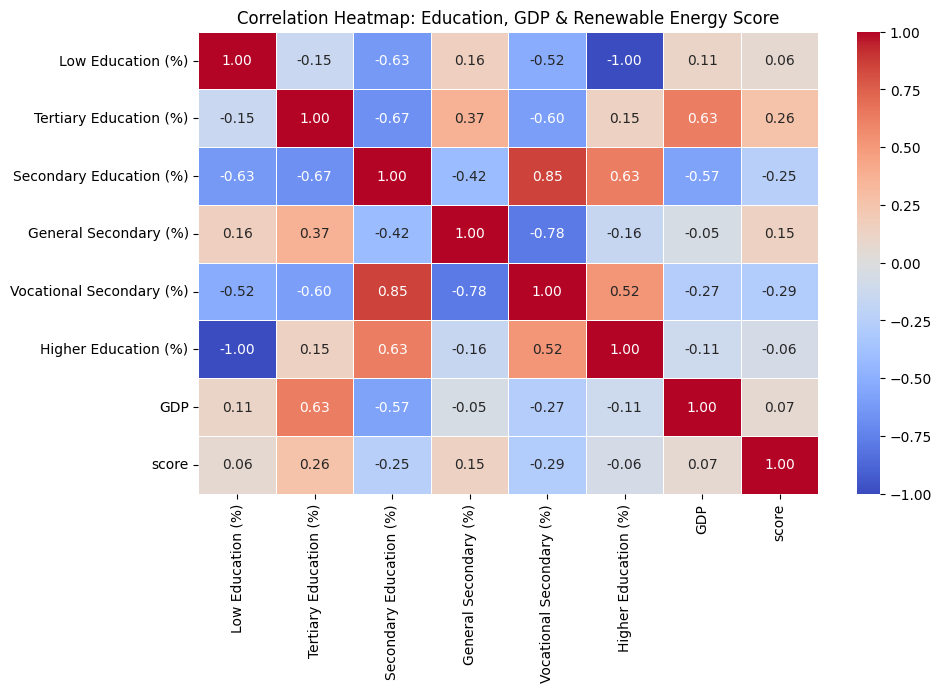

In [190]:
correlation_matrix = features.corr()

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap: Education, GDP & Renewable Energy Score")
plt.show()

In [191]:
def run_correlation_analysis(df_indep_var: pd.DataFrame, country_of_interest: str) -> pd.DataFrame:
    """
    Univariate Correlation-Tests for country-based correlations.
    The dependent variable is the Energy Share.
    """
    
    # Ensure eurostat_dataset and NRG_IND_REN are defined elsewhere
    try:
        energy_share_all_countries = eurostat_dataset(NRG_IND_REN)
    except NameError:
        raise NameError("Ensure `eurostat_dataset` and `NRG_IND_REN` are defined before calling this function.")
    
    energy_share_all_countries = energy_share_all_countries.reset_index()

    # Filter data for the country of interest
    if 'Country' not in energy_share_all_countries.columns:
        raise KeyError("The 'Country' column is missing in the dataset.")
    
    df_single_country = energy_share_all_countries[energy_share_all_countries['Country'] == country_of_interest]
    if df_single_country.empty:
        raise ValueError(f"No data found for the country: {country_of_interest}")

    df_dep_var = df_single_country

    # Identify common years between dependent and independent variables
    common_years = list(set(df_dep_var.columns).intersection(set(df_indep_var.columns)))
    common_years = [col for col in common_years if str(col).startswith(('1', '2'))]

    if not common_years:
        raise ValueError("No common year columns found between dependent and independent variables.")

    # Sort years numerically and ensure they are strings
    common_years_sorted = [str(year) for year in sorted(common_years, key=lambda x: int(x))]

    # Reset index without adding it as a column
    df_dep_var = df_dep_var.reset_index(drop=True)
    df_indep_var = df_indep_var.reset_index(drop=True)

    # Select relevant columns
    required_columns_dep = ['Country', 'Energy balance'] + common_years_sorted
    required_columns_indep = ['Country'] + common_years_sorted

    for col in required_columns_dep:
        if col not in df_dep_var.columns:
            raise KeyError(f"Missing required column in dependent variable DataFrame: {col}")
    
    for col in required_columns_indep:
        if col not in df_indep_var.columns:
            raise KeyError(f"Missing required column in independent variable DataFrame: {col}")

    df_dep_var = df_dep_var[required_columns_dep]
    df_indep_var = df_indep_var[required_columns_indep]

    # Check for non-empty DataFrames after filtering
    if df_dep_var.empty or df_indep_var.empty:
        raise ValueError("Dependent or independent variable DataFrame is empty after filtering.")

    # Initialize a list to store correlation results
    correlation_results = []

    # Perform correlation analysis for every corresponding row in both DataFrames
    for dep_idx, dep_row in df_dep_var.iterrows():
        try:
            # Extract numerical data from year-related columns
            dep_first_col_index = next((i for i, col in enumerate(df_dep_var.columns) if str(col).startswith(('1', '2'))), None)
            indep_first_col_index = next((i for i, col in enumerate(df_indep_var.columns) if str(col).startswith(('1', '2'))), None)

            if dep_first_col_index is None or indep_first_col_index is None:
                continue  # Skip if no valid year columns are found

            numerical_df_dep_var = dep_row.iloc[dep_first_col_index:].astype(float)
            for indep_idx, indep_row in df_indep_var.iterrows():
                numerical_df_indep_var = indep_row.iloc[indep_first_col_index:].astype(float)

                # Ensure equal lengths before calculating correlation
                if len(numerical_df_dep_var) != len(numerical_df_indep_var):
                    continue  # Skip this pair if lengths don't match

                # Calculate correlation
                correlation_value = numerical_df_dep_var.corr(numerical_df_indep_var)

                # Concatenate values before dep_first_col_index and indep_first_col_index as identifiers
                dep_identifier = "_".join(map(str, dep_row.iloc[:dep_first_col_index].values))
                indep_identifier = "_".join(map(str, indep_row.iloc[:indep_first_col_index].values))

                # Store the result with descriptive identifiers instead of row indices
                correlation_results.append({
                    "dependent_identifier": dep_identifier,
                    "independent_identifier": indep_identifier,
                    "correlation": correlation_value
                })

        except Exception as e:
            print(f"Error calculating correlation for Row {dep_idx}: {e}")
            continue

    # Convert results to a DataFrame for easier analysis
    correlation_results_df = pd.DataFrame(correlation_results)

    # Save results to a CSV file (optional)
    if not correlation_results_df.empty:
        correlation_results_df.to_csv("row_correlation_results.csv", index=False)
        print("Row-wise correlation analysis completed. Results saved to 'row_correlation_results.csv'.")
    else:
        print("No correlations were calculated. The results DataFrame is empty.")

    return correlation_results_df


In [192]:
energy_balances_all_countries = eurostat_dataset(NRG_BAL_S)
energy_balances_all_countries = energy_balances_all_countries.reset_index()

energy_balances_austria = energy_balances_all_countries[energy_balances_all_countries['Country'] == "Austria"]

energy_balances_europe = subset_to_eu_countries(energy_balances_austria)

run_correlation_analysis(energy_balances_europe,"Austria")

Row-wise correlation analysis completed. Results saved to 'row_correlation_results.csv'.


dependent_identifier independent_identifier  \
0                    Austria_Renewable energy sources                Austria   
1                    Austria_Renewable energy sources                Austria   
2                    Austria_Renewable energy sources                Austria   
3                    Austria_Renewable energy sources                Austria   
4     Austria_Renewable energy sources in electricity                Austria   
5     Austria_Renewable energy sources in electricity                Austria   
6     Austria_Renewable energy sources in electricity                Austria   
7     Austria_Renewable energy sources in electricity                Austria   
8   Austria_Renewable energy sources in heating an...                Austria   
9   Austria_Renewable energy sources in heating an...                Austria   
10  Austria_Renewable energy sources in heating an...                Austria   
11  Austria_Renewable energy sources in heating an...                Austria   
12      Austria_Renewable energy sources in transport                Austria   
13      Austria_Renewable energy sources in transport                Austria   
14      Austria_Renewable energy sources in transport                Austria   
15      Austria_Renewable energy sources in transport                Austria   

    correlation  
0      0.224921  
1     -0.196439  
2           NaN  
3     -0.197075  
4      0.274723  
5     -0.276654  
6           NaN  
7     -0.279349  
8      0.290494  
9     -0.064243  
10          NaN  
11    -0.079142  
12     0.017047  
13    -0.170037  
14          NaN  
15    -0.202902

In [193]:

# My Assumptions: 
'''
Quantification for level of adoption: NRG_IND_REN
Dependent Variables:
- Renewable energy sources
- Renewable energy sources in transport
- Renewable energy sources in electricity
- Renewable energy sources in heating and cooling
'''

# Load Dependent variables for corrlation analysis

energy_share_all_countries = eurostat_dataset(NRG_IND_REN)
energy_share_europe = subset_to_eu_countries(energy_share_all_countries)
print(energy_share_europe.head())
energy_share_europe.T.to_csv("energy_share_europe.csv")

'''
Which datasources could be relevant? 

- Energy balances - NRG_BAL_S
# Potential Variables of interest:
    Energy balance
    Available for final consumption
    Gross available energy
    Primary energy consumption (Europe 2020-2030)
    Total energy supply
'''
energy_balances_all_countries = eurostat_dataset(NRG_BAL_S)
energy_balances_europe = subset_to_eu_countries(energy_balances_all_countries)
energy_balances_europe.to_csv("energy_balances_europe.csv")


'''
- Supply and transformation of solid fossil fuels -> left out due to lack of data


- Energy prices - NRG_PC_204
# Potential Variables of interest:
Energy consumption
    Consumption of kWh - all bands
    Consumption less than 1 000 kWh - band DA
    Consumption from 1 000 kWh to 2 499 kWh - band DB
    Consumption from 2 500 kWh to 4 999 kWh - band DC
    Consumption from 5 000 kWh to 14 999 kWh - band DD
    Consumption for 15 000 kWh or over - band DE
'''
energy_prices_all_countries = eurostat_dataset(NRG_PC_204)
energy_prices_europe = subset_to_eu_countries(energy_prices_all_countries)


'''
- Population metrics along - EDAT_LFSE_03
# Potential Variables of interest:
Age class	
    From 15 to 64 years	
    From 20 to 24 years	
    From 25 to 34 years	
    From 25 to 64 years	
    From 30 to 34 years	
    From 30 to 54 years	
    From 35 to 44 years	
    From 45 to 54 years	
    From 45 to 64 years	
    From 55 to 64 years	


International Standard Classification of Education (ISCED 2011)
    Less than primary, primary and lower secondary education (levels 0-2)
    Tertiary education (levels 5-8)
    Upper secondary and post-secondary non-tertiary education (levels 3 and 4)
    Upper secondary and post-secondary non-tertiary education (levels 3 and 4) - general
    Upper secondary and post-secondary non-tertiary education (levels 3 and 4) - vocational
    Upper secondary, post-secondary non-tertiary and tertiary education (levels 3-8)
	
... TODO: What else? 
'''
population_metrics_all_countries = eurostat_dataset(EDAT_LFSE_03)
population_metrics_europe = subset_to_eu_countries(population_metrics_all_countries)





                                                           2004    2005  \
Country Energy balance                                                    
Austria Renewable energy sources                         22.553  24.353   
        Renewable energy sources in electricity          61.627  62.901   
        Renewable energy sources in heating and cooling  20.165  22.817   
        Renewable energy sources in transport             4.532   5.070   
Belgium Renewable energy sources                          1.916   2.325   

                                                           2006    2007  \
Country Energy balance                                                    
Austria Renewable energy sources                         26.276  28.144   
        Renewable energy sources in electricity          63.527  65.666   
        Renewable energy sources in heating and cooling  24.491  27.142   
        Renewable energy sources in transport             7.532   8.241   
Belgium Renewable energy